In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
weather = pd.read_csv(r'C:\Users\김상휘\Desktop\dacon\weather_v2.csv')
target = pd.read_csv(r'C:\Users\김상휘\Desktop\dacon\target_v2.csv')

###### 데이터 결측치 확인

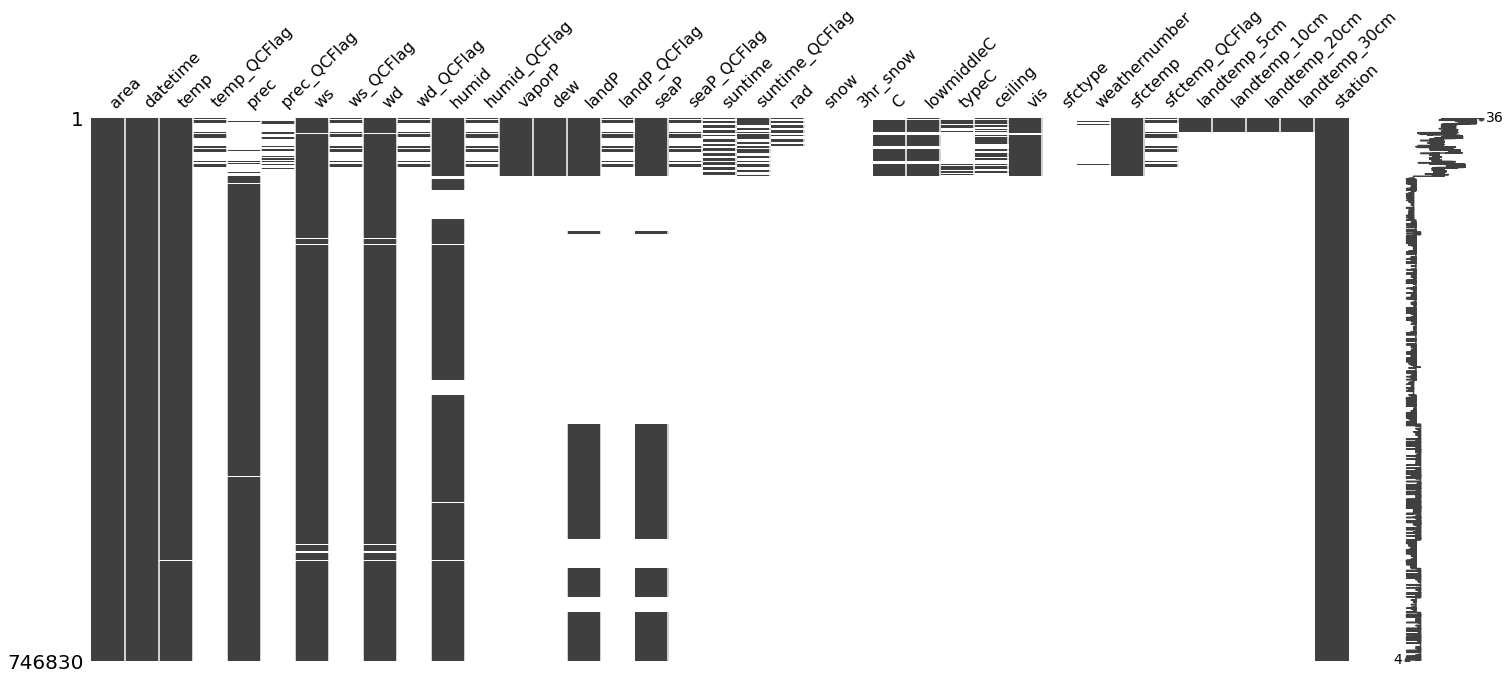

In [3]:
import missingno as msno
msno.matrix(weather)

##### smp, supply, weather 간의 상관관계 확인

In [4]:
weather['date'] = weather['datetime'].apply(lambda x: x[:10])

In [5]:
weather_mean = weather.groupby('date').mean().reset_index(drop = True)

In [6]:
# target과 weather의 상관관계 파악
pd.concat([target,weather_mean],axis=1).corr().loc['smp_max':'supply','area':].abs().mean().sort_values(ascending = False).head(10)

landtemp_30cm    0.323563
landtemp_5cm     0.300492
landtemp_20cm    0.293111
landtemp_10cm    0.292360
temp             0.291700
sfctemp          0.283049
dew              0.269303
vaporP           0.246189
landP            0.223619
seaP             0.182458
dtype: float64

##### smp, supply 의 시계열적 특성을 이용하기 위해 datetime 속성으로 변환

In [7]:
target['date'] = pd.to_datetime(target['date'])

In [8]:
target['year'] = target['date'].dt.year
target['month'] = target['date'].dt.month
target['day'] = target['date'].dt.day
target['dayofweek'] = target['date'].dt.dayofweek

##### 공공데이터 공휴일 API -> 공휴일 특성  추가

In [9]:
import requests
import xmltodict
import json

In [10]:
key = "MoWjfkWS0aa1pVz1%2B38Ec1KusKDhrxZx4sU3I0RdIQvIcMjNUa6O454%2BtRJLpmA2Mi2FeJ1SjTyBGlNxLM6Mjw%3D%3D"

holidays = pd.DataFrame(columns=['date','name'])
date_list = []
name_list = []

for year_ in ['2018','2019','2020']:    
    for month in ['01','02','03','04','05','06','07','08','09','10','11','12']:
        url = "http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getHoliDeInfo?solYear="+year_+"&solMonth="+month+"&ServiceKey="+key
        content = requests.get(url).content

        #xml을 json으로 변환
        dict = xmltodict.parse(content)

        #json 파일로 변환
        jsonString = json.dumps(dict['response']['body'], ensure_ascii = False) #'아스키코드가 아니다' 라는 파라미터 추가

        #파이썬에서 다룰수 있게 변환
        jsonObj = json.loads(jsonString)

        if jsonObj['items'] == None:
            continue

        holi_dict = jsonObj['items']['item']

        if type(holi_dict) == list: 
            for i in range(len(holi_dict)):
                date_list.append(holi_dict[i]['locdate'])
                name_list.append(holi_dict[i]['dateName'])
        else:
            date_list.append(holi_dict['locdate'])
            name_list.append(holi_dict['dateName'])

date_arr = np.array(date_list)
name_arr = np.array(name_list)

holidays['date'] = date_arr
holidays['name'] = name_arr
holidays['date'] = pd.to_datetime(holidays['date'])

In [11]:
# 데이터 합치기
target = pd.merge(target,holidays,on='date',how='left')

In [12]:
# 열 이름 변경
names = target.columns.tolist()
names[names.index('name')] = 'holidays'
target.columns = names

In [13]:
# 공휴일 특성 이진수로 변경
target['holidays'].fillna(0, inplace = True)

for i in range(len(target)):
    if target['holidays'][i] !=0:
        target['holidays'][i] = 1

# 타입 변경
target['holidays'] = target['holidays'].astype(int)

#### 유가 데이터 수집

In [14]:
import time
from datetime import datetime

def get_oil_price(code):
    delay = 0.01
    page = 1
    result = []
    start_date = '2018.02.01'
    end_date = '2020.05.18'
    start_time = datetime.now()
    
    # 수집
    print('[{}] 데이터 수집을 시작합니다. (code: {})'.format(start_time.strftime('%Y/%m/%d %H:%M:%S'), code))
    while(True):
        url = 'https://finance.naver.com/marketindex/worldDailyQuote.nhn?marketindexCd={}&fdtc=2&page={}'.format(code, page)
        data = pd.read_html(url)[0].dropna()
        if page != 1:
            try:
                if '2018.02.01' in data.iloc[:,0].values:
                    data = data.loc[:data.iloc[:,0].values.tolist().index(start_date),]
                    result.append(data)
                    break
            except:
                break
        result.append(data)
        page += 1
        time.sleep(delay)
    
    # 가공
    oil_price = pd.concat(result).reset_index(drop=True)
    oil_price.columns = ['date', 'price', '전일대비', '등락율']
    oil_price = oil_price.loc[oil_price['date'].tolist().index(end_date):,]
    oil_price['date'] = oil_price['date'].apply(lambda x: datetime.strptime(x, '%Y.%m.%d'))
    oil_price = oil_price[['date', 'price']]
    oil_price.insert(0, 'code', code)
    oil_price = oil_price[::-1].reset_index(drop=True)
    
    end_time = datetime.now()
    print('[{}] 데이터 수집을 종료합니다. (code: {}, 수집시간: {}초, 데이터수: {:,}개)'.format(end_time.strftime('%Y/%m/%d %H:%M:%S'), code, (end_time-start_time).seconds, len(oil_price)))
    return oil_price

In [15]:
oil_price_du = get_oil_price('OIL_DU')
oil_price_wti = get_oil_price('OIL_CL')
oil_price_brent = get_oil_price('OIL_BRT')

[2020/05/24 18:14:53] 데이터 수집을 시작합니다. (code: OIL_DU)
[2020/05/24 18:15:04] 데이터 수집을 종료합니다. (code: OIL_DU, 수집시간: 11초, 데이터수: 577개)
[2020/05/24 18:15:04] 데이터 수집을 시작합니다. (code: OIL_CL)
[2020/05/24 18:15:15] 데이터 수집을 종료합니다. (code: OIL_CL, 수집시간: 11초, 데이터수: 578개)
[2020/05/24 18:15:15] 데이터 수집을 시작합니다. (code: OIL_BRT)
[2020/05/24 18:15:28] 데이터 수집을 종료합니다. (code: OIL_BRT, 수집시간: 12초, 데이터수: 588개)


In [16]:
oil_list = []
oil_list.append(oil_price_du)
oil_list.append(oil_price_wti)
oil_list.append(oil_price_brent)
code_list = ['OIL_DU','OIL_CL','OIL_BRT']

for i, code in enumerate(code_list):
    oil_list[i].drop(['code'],axis=1,inplace=True)
    oil_list[i].columns = ['date',str(code)+'_price']

In [17]:
start = '2018-02-01'
end = '2020-05-18'
daily_price_oil = pd.DataFrame(columns = ['date'])
date_range = pd.date_range(start,end,freq = 'D')
daily_price_oil['date'] = date_range

In [18]:
for d in oil_list:
    daily_price_oil = daily_price_oil.merge(d,how='outer')

In [19]:
daily_price_oil['mean'] = round(daily_price_oil.mean(axis=1),2)
daily_price_oil = daily_price_oil.loc[:,['date','mean']]
daily_price_oil.columns = ['date','oil_price']

In [20]:
# 총 세번 진행
daily_price_oil['oil_price'][daily_price_oil['oil_price'].isna()] = daily_price_oil.shift(-1)['oil_price'][daily_price_oil['oil_price'].isna()]
daily_price_oil['oil_price'][daily_price_oil['oil_price'].isna()] = daily_price_oil.shift(-1)['oil_price'][daily_price_oil['oil_price'].isna()]
daily_price_oil['oil_price'][daily_price_oil['oil_price'].isna()] = daily_price_oil.shift(-1)['oil_price'][daily_price_oil['oil_price'].isna()]

In [21]:
target['oil_price'] = daily_price_oil['oil_price']

In [23]:
target['oil_price'].isnull().sum()

0

##### weather 데이터 전처리 // 
- ASOS 지역 기온만 사용 (제주, 고산, 성산, 서귀포)

- 기온은 지역별 기온의 중앙값 사용

- 선정된 기온에서 그 날의 최소, 최대, 평균기온 찾아 target에 추가

- ASOS 지역 기온만 사용 (제주, 고산, 성산, 서귀포)

In [24]:
weather = weather[weather['station'] == 'ASOS']

- 기온은 지역별 기온의 중앙값 사용

In [25]:
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather = weather.loc[:,'area':'temp']

In [26]:
# 필요없는 'area'열 삭제, 열 이름에 area 추가
# area별로 새로운 list에 묶어서 간단히 해결

weather_list = []
for area in weather['area'].unique():
    weather_list.append(weather[weather['area']==area].copy())

for i, area in enumerate(weather['area'].unique()):
    weather_list[i].drop(['area'],axis=1,inplace=True)
    weather_list[i].columns = ['datetime',str(area)+'_temp']

In [27]:
# 각 지역의 시간별 기온을 합쳐서 중앙값으로 만든 새로운 데이터 프레임

start = '2018-02-01'
end = '2020-05-18'
hourly_temperature = pd.DataFrame(columns = ['datetime'])
date_range = pd.date_range(start,end,freq = 'H')
hourly_temperature['datetime'] = date_range

In [28]:
# 시간별 온도 데이터 중앙값(같은 데이터 프레임에 병합해서 구함)
for d in weather_list:
    hourly_temperature = hourly_temperature.merge(d,how='outer')
hourly_temperature['median'] = hourly_temperature.median(axis=1)
hourly_temperature = hourly_temperature.loc[:,['datetime','median']]
hourly_temperature.columns = ['date','temperature']

In [29]:
# 결측치 1시간 후의 온도로 처리
hourly_temperature['temperature'][hourly_temperature['temperature'].isna()] = hourly_temperature.shift(-1)['temperature'][hourly_temperature['temperature'].isna()]

In [30]:
hourly_temperature['temperature'].isnull().sum()

0

- 선정된 기온에서 그 날의 최소, 최대, 평균기온 찾아 target에 추가

In [31]:
start = '2018-02-01'
end = '2020-05-18'
daily_temperature = pd.DataFrame(columns = ['date'])
date_range = pd.date_range(start, end, freq='D')
daily_temperature['date'] = date_range

In [32]:
# 해당 날짜의 최대, 최소값을 찾기 위해 24시간을 한 행으로 나타냄
for d in range(daily_temperature.shape[0]):
    for h in range(24):
        daily_temperature.loc[d, 'temp_h'+str(h)] = hourly_temperature['temperature'][d*24:d*24+24][d*24+h]

In [33]:
daily_temperature['temp_max'] = daily_temperature.loc[:,'temp_h0':].max(axis=1)
daily_temperature['temp_min'] = daily_temperature.loc[:,'temp_h0':].min(axis=1)
daily_temperature['temp_mean'] = daily_temperature.loc[:,'temp_h0':].mean(axis=1)

In [34]:
# target값에 추가
target['temp_max'] = daily_temperature['temp_max']
target['temp_min'] =daily_temperature['temp_min']
target['temp_mean'] = daily_temperature['temp_mean']

# EDA 탐색적 자료분석

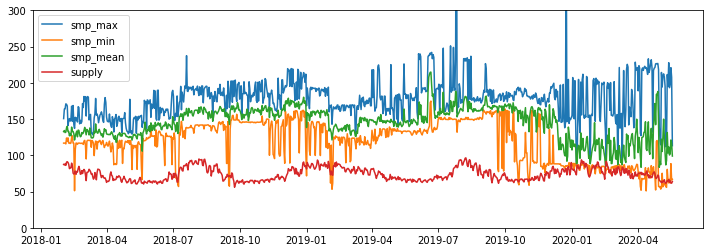

In [36]:
plt.rcParams['figure.figsize'] = [12,4]
plt.plot(target.loc[:, 'date'], target.loc[:,'smp_max'],label='smp_max')
plt.plot(target.loc[:, 'date'], target.loc[:, 'smp_min'], label='smp_min')
plt.plot(target.loc[:, 'date'], target.loc[:, 'smp_mean'], label='smp_mean')
plt.plot(target.loc[:, 'date'], target.loc[:, 'supply'], label='supply')
plt.ylim(0,300)
plt.legend()
plt.show()

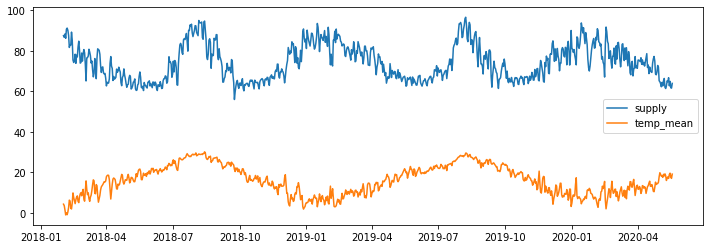

In [37]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.plot(target.loc[:, 'date'], target.loc[:, 'supply'], label='supply')
plt.plot(target.loc[:, 'date'], target.loc[:, 'temp_mean'], label='temp_mean')
plt.legend()
plt.show()

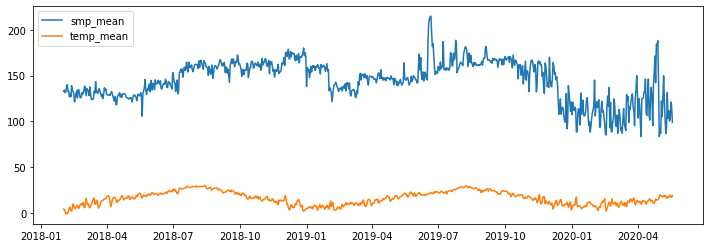

In [38]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.plot(target.loc[:, 'date'], target.loc[:, 'smp_mean'], label='smp_mean')
plt.plot(target.loc[:, 'date'], target.loc[:, 'temp_mean'], label='temp_mean')
plt.legend()
plt.show()

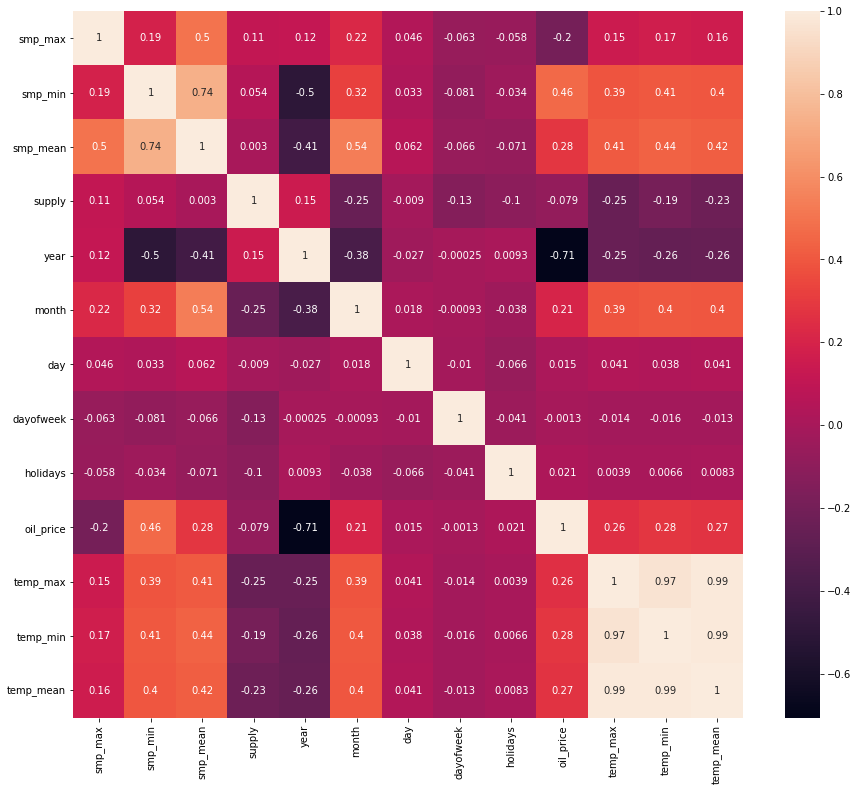

In [39]:
plt.rcParams['figure.figsize'] = [15,13]
sns.heatmap(target.corr(),annot=True)

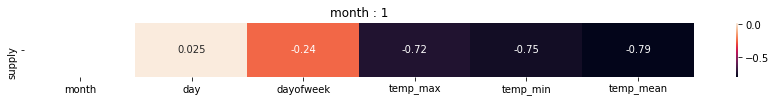

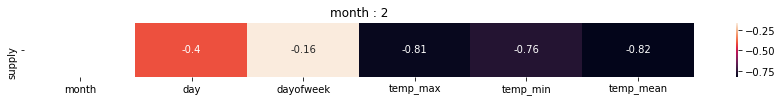

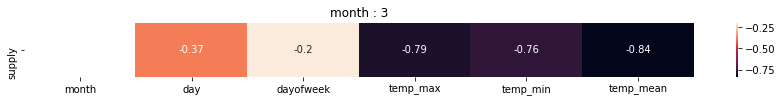

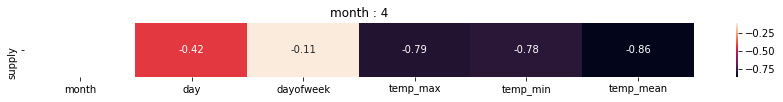

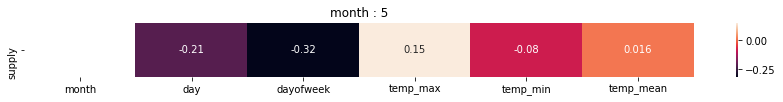

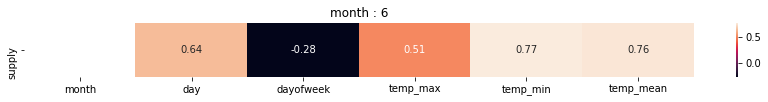

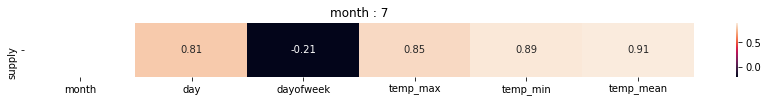

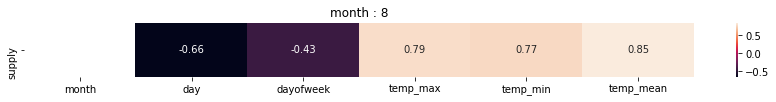

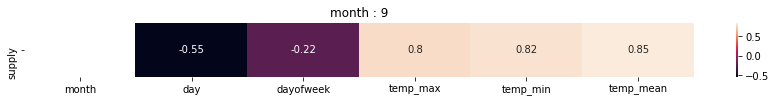

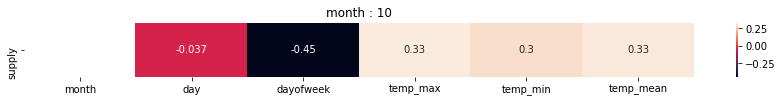

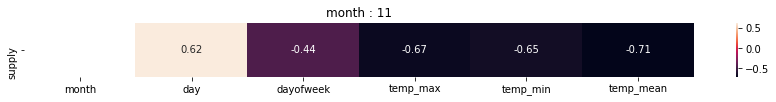

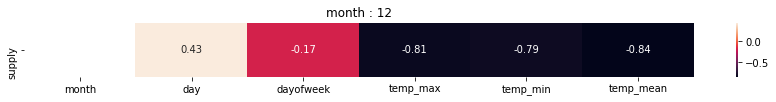

In [40]:
plt.rcParams['figure.figsize'] = [15, 1]
for m in range(1, 13):
    sns.heatmap(target[target['date'].dt.month == m].corr().loc[['supply'],['month', 'day', 'dayofweek', 'temp_max', 'temp_min', 'temp_mean']], annot=True)
    plt.title('month : '+ str(m))
    plt.show()

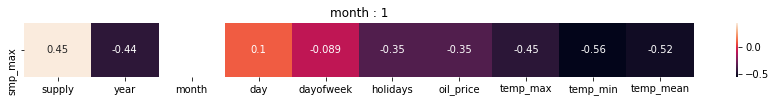

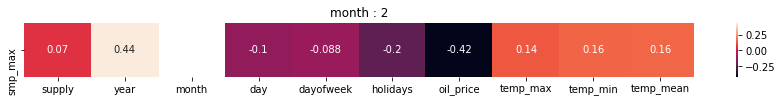

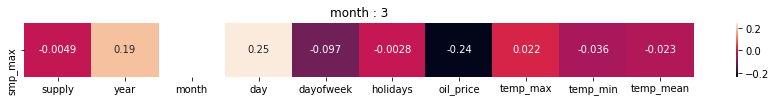

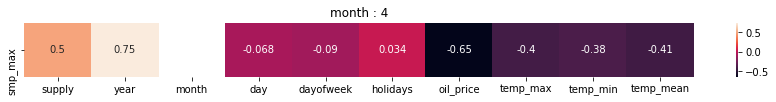

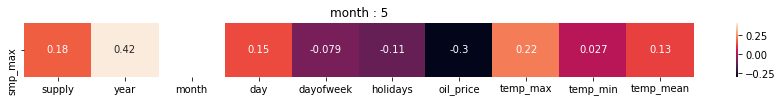

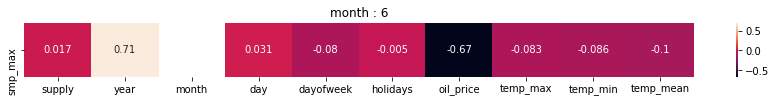

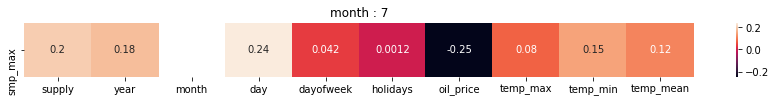

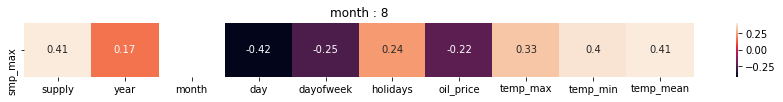

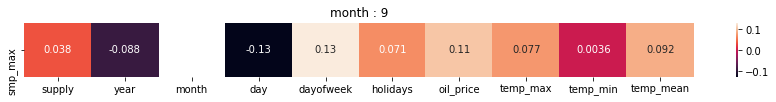

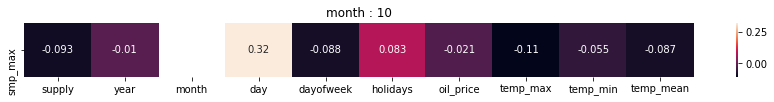

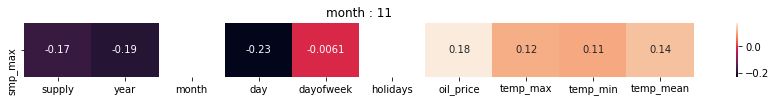

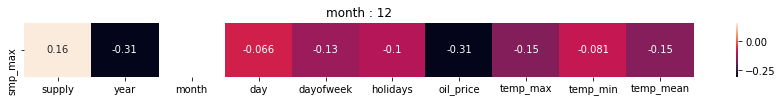

In [41]:
plt.rcParams['figure.figsize'] = [15, 1]
for m in range(1, 13):
    sns.heatmap(target[target['date'].dt.month == m].corr().loc[['smp_max'],'supply':], annot=True)
    plt.title('month : '+ str(m))
    plt.show()

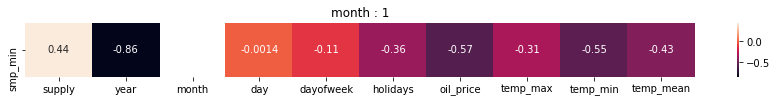

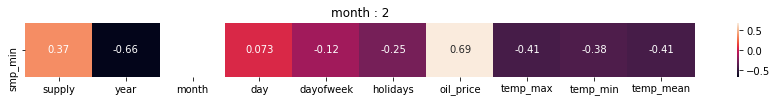

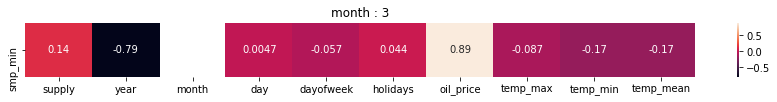

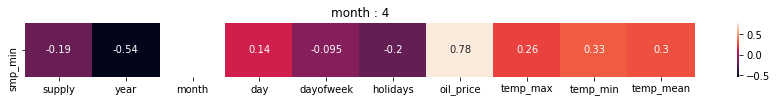

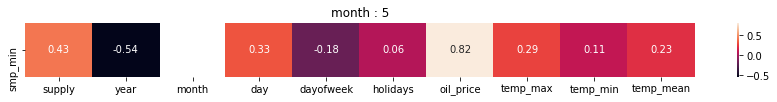

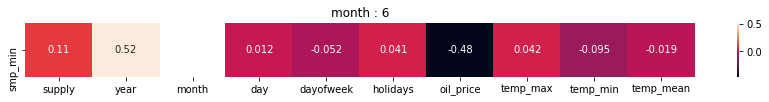

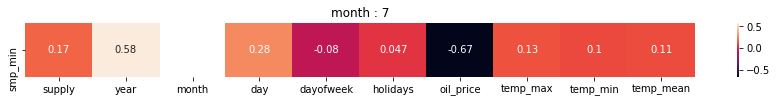

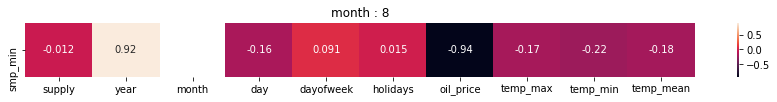

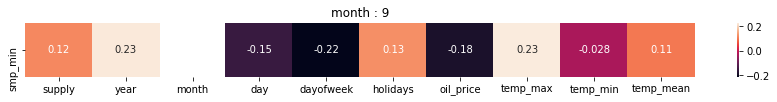

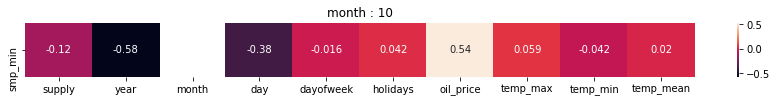

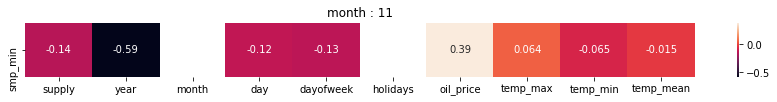

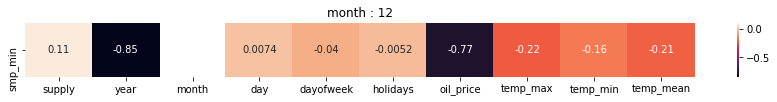

In [42]:
plt.rcParams['figure.figsize'] = [15, 1]
for m in range(1, 13):
    sns.heatmap(target[target['date'].dt.month == m].corr().loc[['smp_min'],'supply':], annot=True)
    plt.title('month : '+ str(m))
    plt.show()

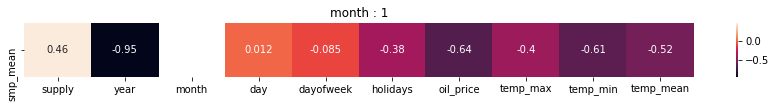

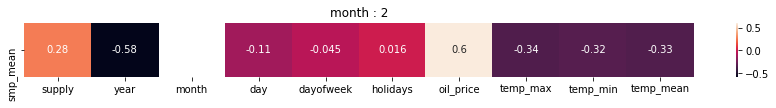

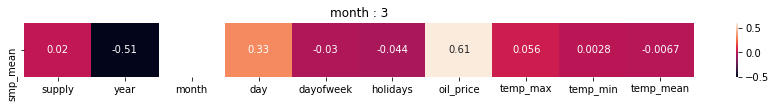

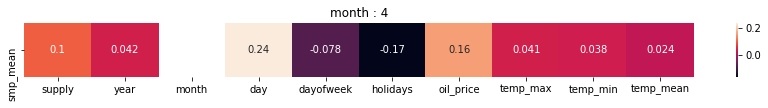

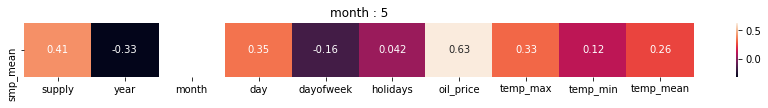

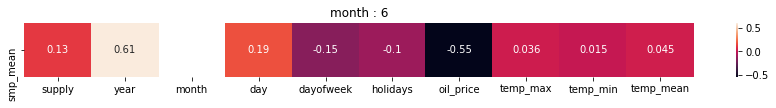

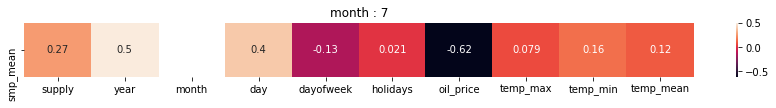

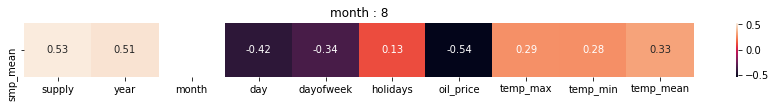

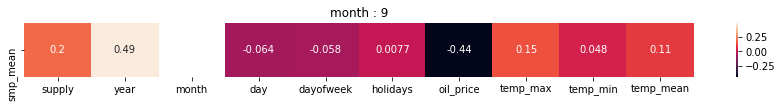

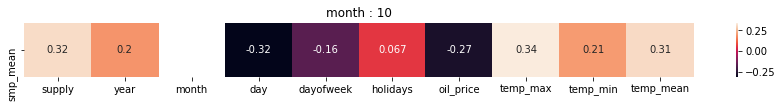

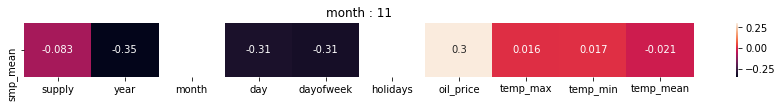

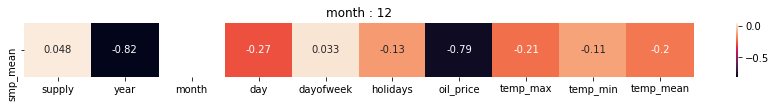

In [43]:
plt.rcParams['figure.figsize'] = [15, 1]
for m in range(1, 13):
    sns.heatmap(target[target['date'].dt.month == m].corr().loc[['smp_mean'],'supply':], annot=True)
    plt.title('month : '+ str(m))
    plt.show()

# 모델 학습 및 검증

#### supply와 날씨데이터 예측

In [44]:
def create_model(d_train,d_val):
    params = {
        'metrics' : 'mae',
        'seed' : 7777
    }
    
    model = lgb.train(params, d_train, 1000, d_val, verbose_eval = 1000, early_stopping_rounds=100)
    
    plt.rcParams['figure.figsize'] = [6,4]
    plt.plot(y_val, '.-', label='y_val')
    plt.plot(model.predict(x_val),'.-', label='y_pred')
    plt.title(str(future)+'days later')
    plt.legend()
    plt.show()
    
    return model

In [45]:
def trans(dataset, start_index, end_index, past, future, x_columns, y_columns):
    dataset.index = range(dataset.shape[0])
    data = []
    labels = []
    
    start_index = start_index+past
    
    if end_index is None:
        end_index = dataset.shape[0]
    
    for i in range(start_index, end_index-future): # 29일부터 마지막의 7일을 뺀 값까지
        indices = np.array(dataset.loc[i-past:i,x_columns])
        data.append(indices) # 0~29일까지의 train 값, 1~30일까지의 값
        
        labels.append(np.array(dataset.loc[i+future,y_columns])) # 29일 부터 7일 후의 supply 값, 30일부터 7일 후의 값
    
    #append를 하면(list) array로 바꿔줄것
    #lgb를 사용하기 위해 하나의 결과값(예상 supply값)을 위해 한달동안의 변수값들을 한 행으로 나타내야함
    data = np.array(data) #(628, 30, 7)
    data = data.reshape(data.shape[0],-1) #(628, 210)
    labels = np.array(labels)
    labels = labels.reshape(-1)
    
    return data, labels

In [46]:
# 최근 30일 정보를 이용하여 n일 후를 예측
past = 29 

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	valid_0's l1: 3.87927


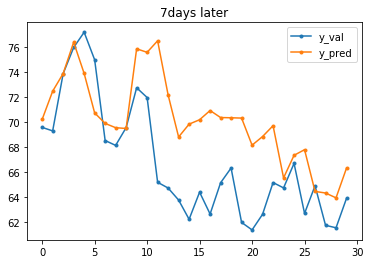

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[29]	valid_0's l1: 5.26009


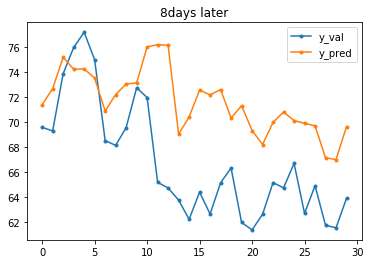

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	valid_0's l1: 5.49612


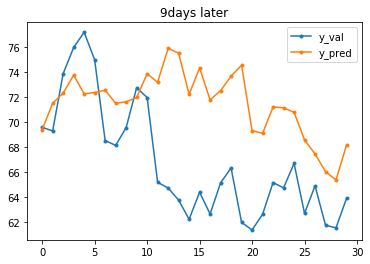

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	valid_0's l1: 6.4738


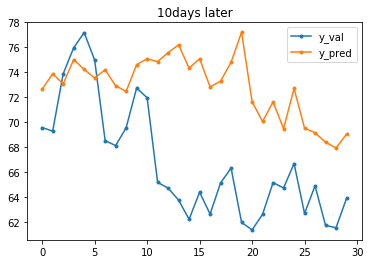

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[68]	valid_0's l1: 6.21628


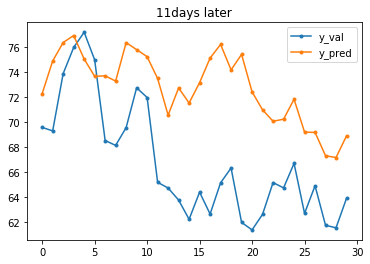

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 6.75063


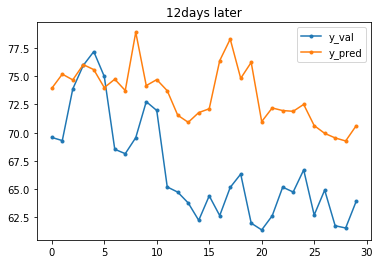

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 6.12282


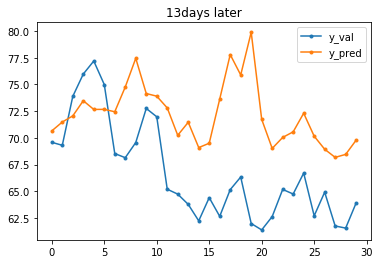

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 6.51962


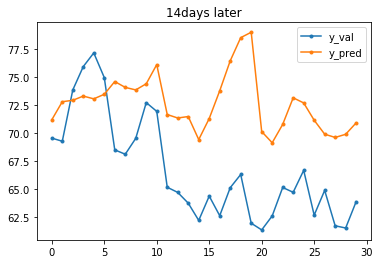

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 6.36434


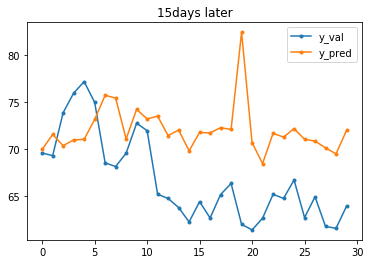

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[34]	valid_0's l1: 6.47976


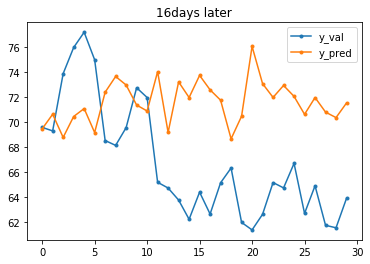

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[36]	valid_0's l1: 6.56957


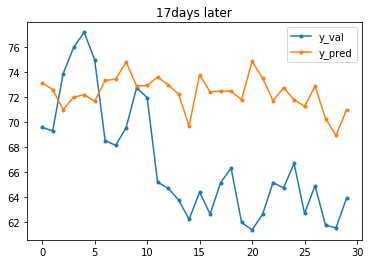

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[272]	valid_0's l1: 5.82104


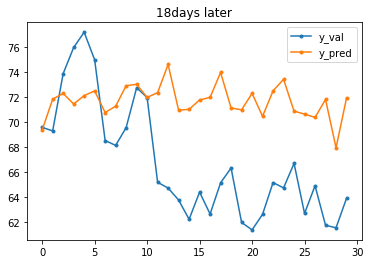

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 7.253


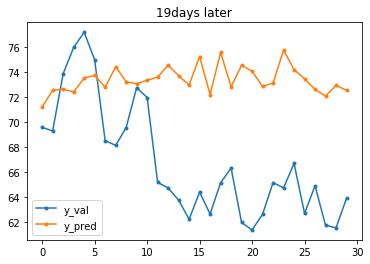

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 6.93932


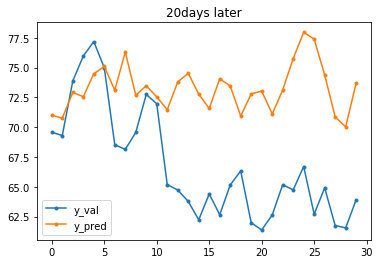

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 7.0607


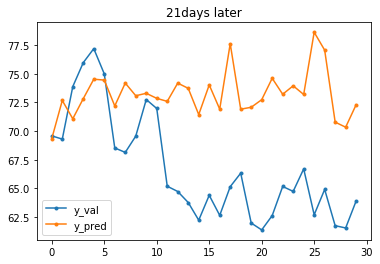

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[32]	valid_0's l1: 7.11673


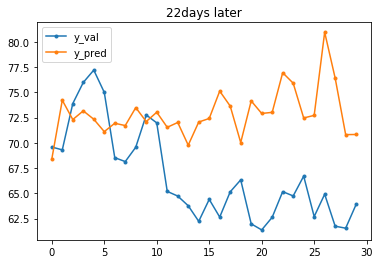

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 8.16459


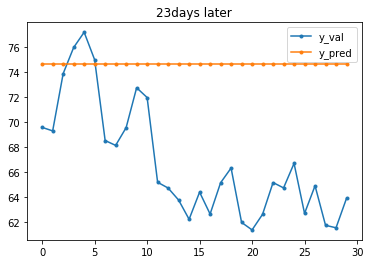

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 7.94872


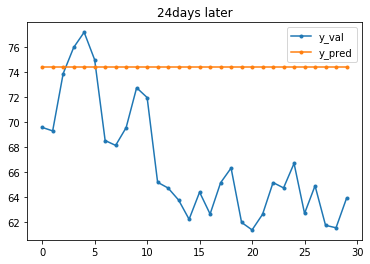

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[43]	valid_0's l1: 7.28386


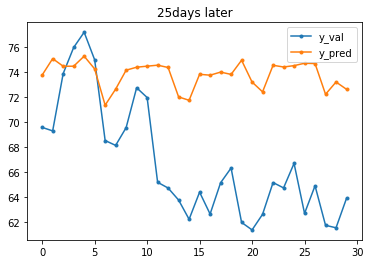

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[12]	valid_0's l1: 6.81155


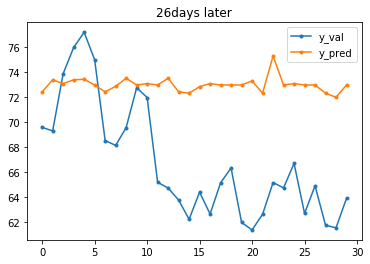

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[14]	valid_0's l1: 6.89949


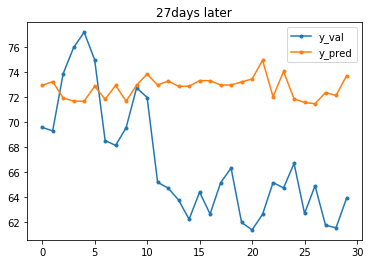

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5]	valid_0's l1: 6.71409


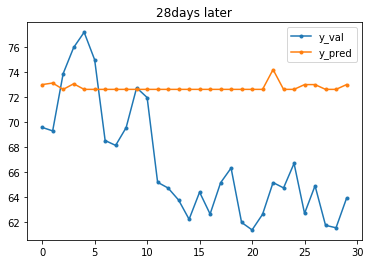

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	valid_0's l1: 7.91655


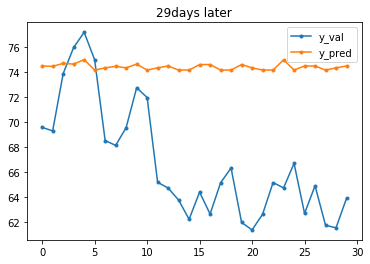

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 7.74971


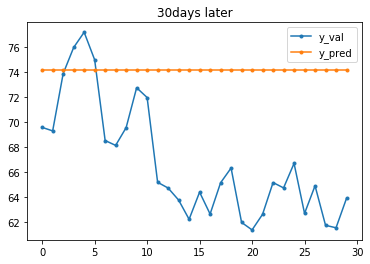

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 8.30163


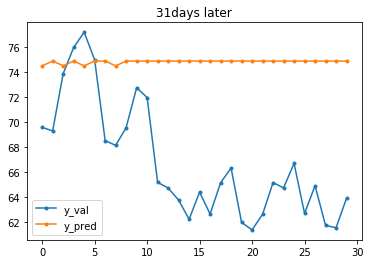

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 8.19202


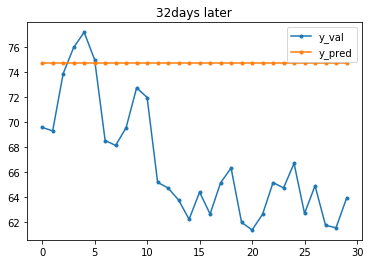

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 8.3887


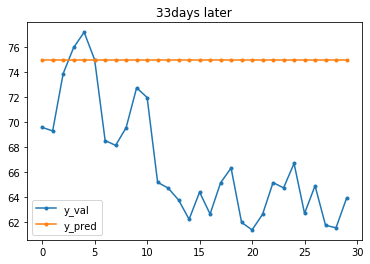

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 8.24611


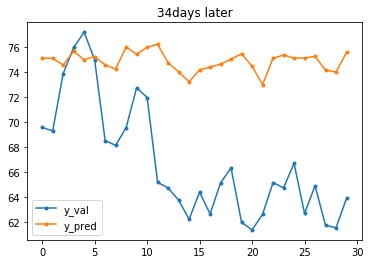

In [47]:
x_columns = ['year','month','day','dayofweek','supply', 'holidays','temp_max', 'temp_min', 'temp_mean','oil_price']
y_columns = ['supply']
supply_models = {}

# 7일~ 34일 후를 예측하는 각각의 모델 구축
for future in range(7,35):
    train_split = target.shape[0]-past-future-30 #마지막 30일은 validation set
    x_train, y_train = trans(target,0,train_split,past,future,x_columns,y_columns)
    x_val, y_val = trans(target,train_split,None,past,future,x_columns,y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)
    
    supply_models[future] = create_model(d_train, d_val)
    print('============================================================')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[267]	valid_0's l1: 14.1127


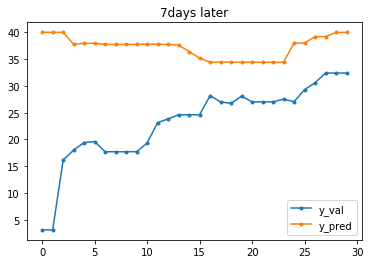

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's l1: 13.6343
Did not meet early stopping. Best iteration is:
[995]	valid_0's l1: 13.6342


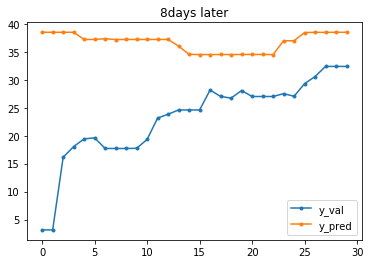

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[453]	valid_0's l1: 15.596


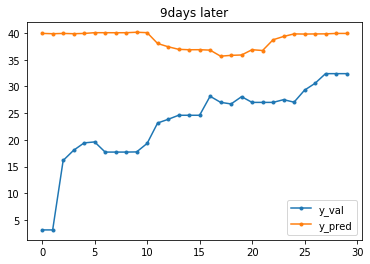

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[453]	valid_0's l1: 16.8571


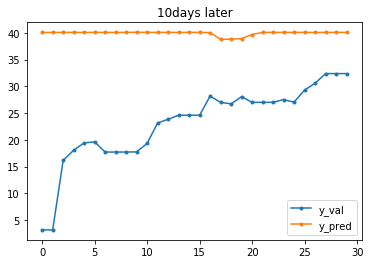

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[419]	valid_0's l1: 18.6583


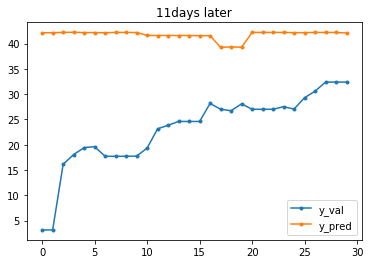

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[695]	valid_0's l1: 23.0589


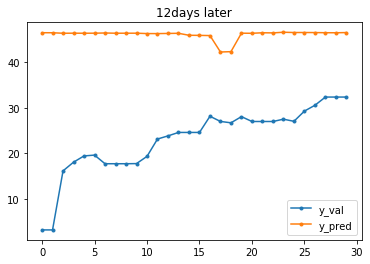

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's l1: 26.8259
Did not meet early stopping. Best iteration is:
[999]	valid_0's l1: 26.8247


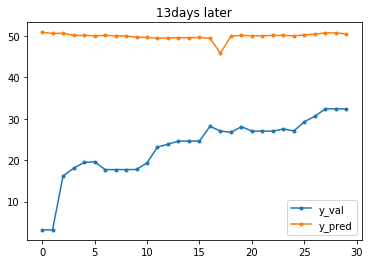

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's l1: 29.2424
Did not meet early stopping. Best iteration is:
[997]	valid_0's l1: 29.2417


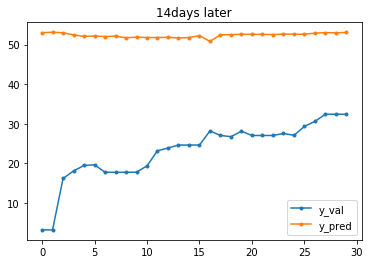

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's l1: 30.0243
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 30.0243


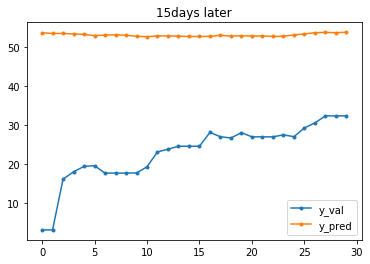

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	valid_0's l1: 29.6198


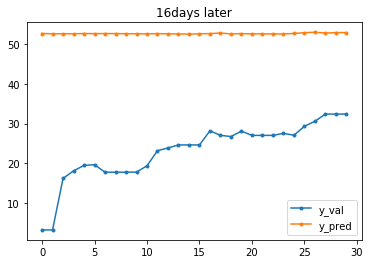

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	valid_0's l1: 29.7168


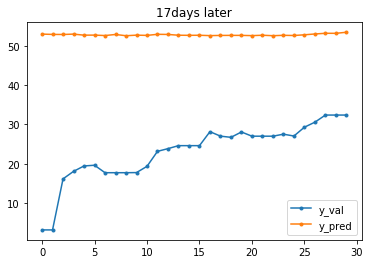

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[542]	valid_0's l1: 30.4826


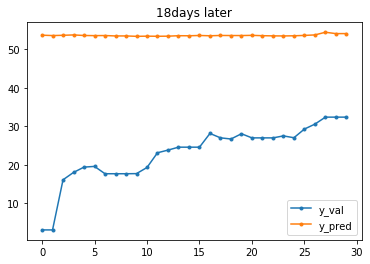

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[139]	valid_0's l1: 31.0688


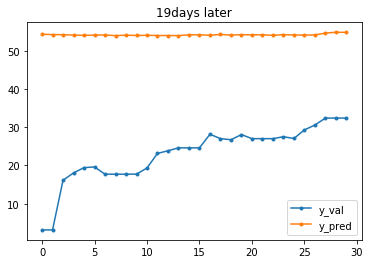

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	valid_0's l1: 34.3936


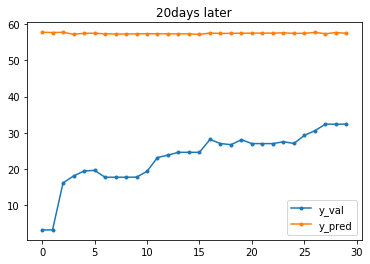

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's l1: 36.6304
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 36.6304


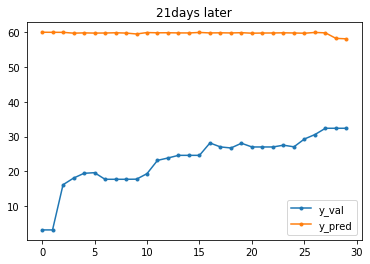

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's l1: 38.1049
Did not meet early stopping. Best iteration is:
[998]	valid_0's l1: 38.1046


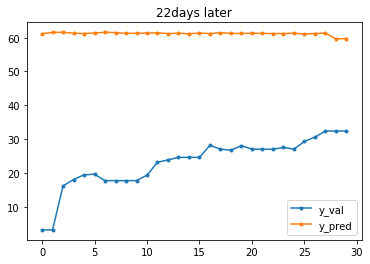

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's l1: 39.4262
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 39.4262


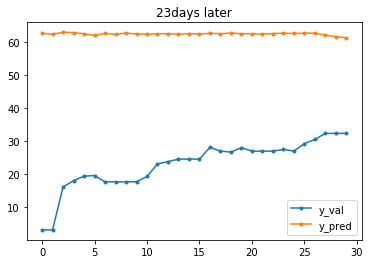

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 42.0273


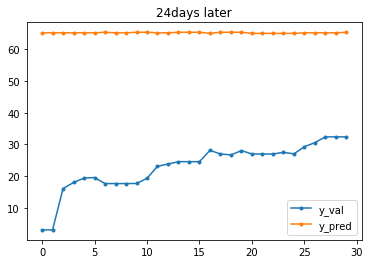

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 42.0841


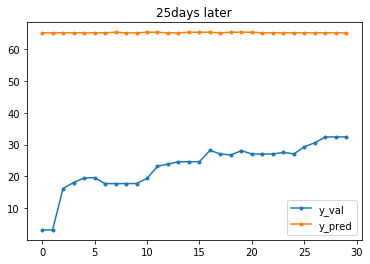

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 42.1096


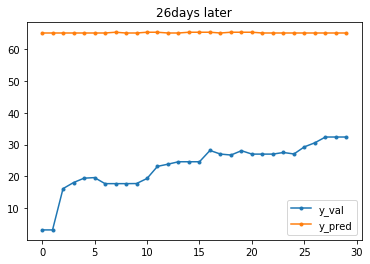

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 42.1179


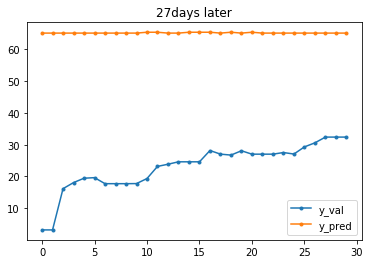

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 42.0945


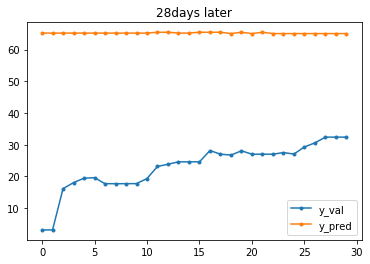

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 42.1224


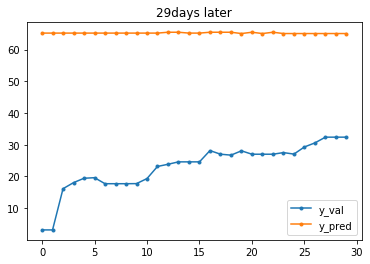

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 41.9887


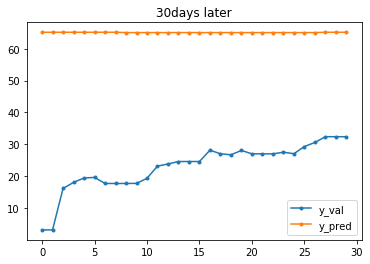

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 42.057


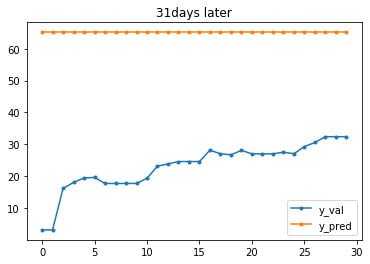

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 42.0693


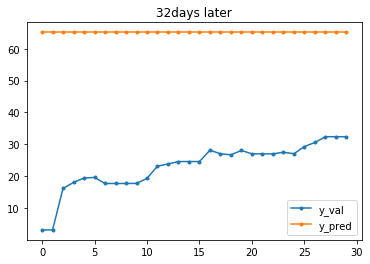

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 42.0051


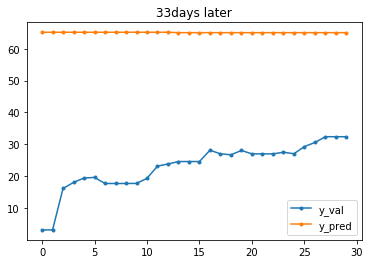

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 42.0144


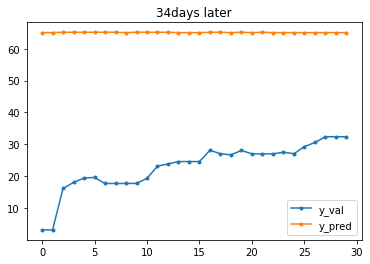

In [48]:
x_columns = ['year','month','day','dayofweek','supply', 'holidays','temp_max', 'temp_min', 'temp_mean','oil_price']
y_columns = ['oil_price']
oil_price_models = {}

# 7일~ 34일 후를 예측하는 각각의 모델 구축
for future in range(7,35):
    train_split = target.shape[0]-past-future-30 #마지막 30일은 validation set
    x_train, y_train = trans(target,0,train_split,past,future,x_columns,y_columns)
    x_val, y_val = trans(target,train_split,None,past,future,x_columns,y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)
    
    oil_price_models[future] = create_model(d_train, d_val)
    print('============================================================')

In [52]:
x_columns = ['year','month','day','temp_max','temp_min','temp_mean']

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[6]	valid_0's l1: 1.93806


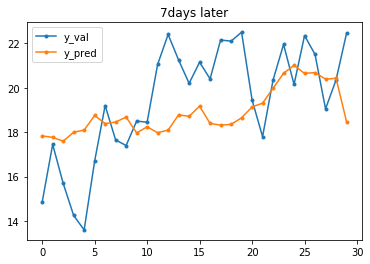

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	valid_0's l1: 1.88958


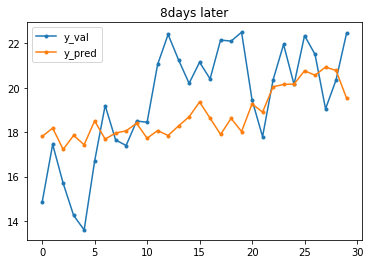

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 1.84869


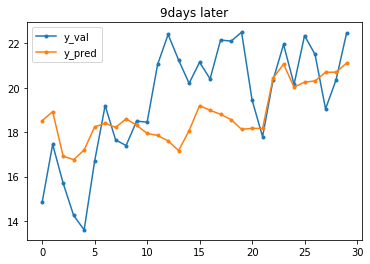

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 1.86814


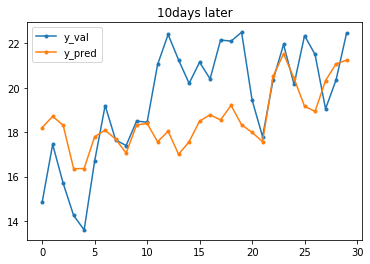

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4]	valid_0's l1: 1.88072


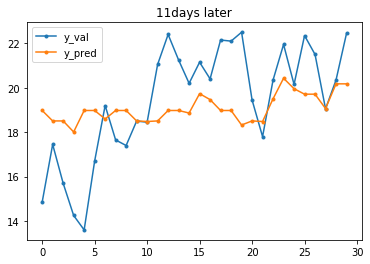

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.05935


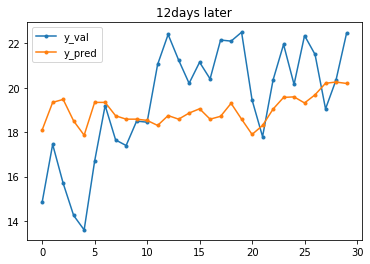

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[6]	valid_0's l1: 1.99617


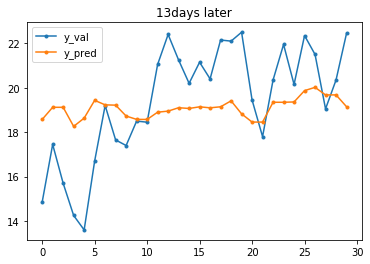

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 1.90405


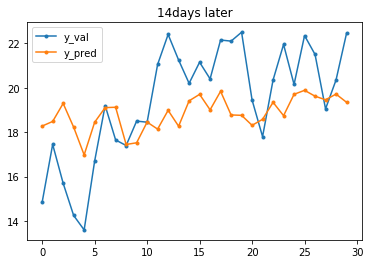

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	valid_0's l1: 1.99432


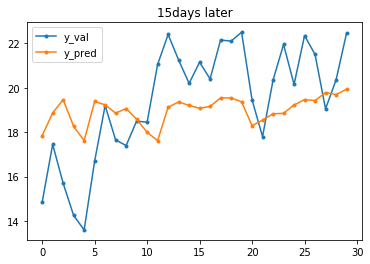

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	valid_0's l1: 1.84558


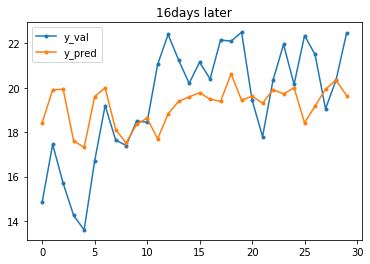

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4]	valid_0's l1: 1.98909


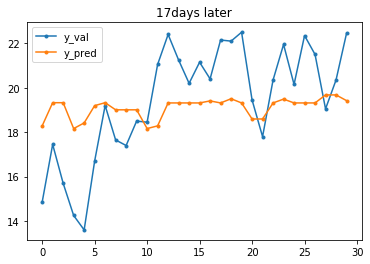

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	valid_0's l1: 1.91602


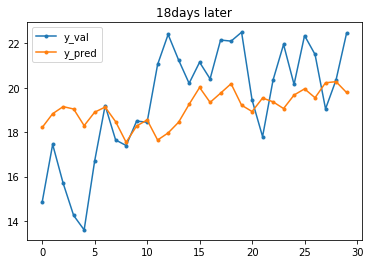

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	valid_0's l1: 1.80643


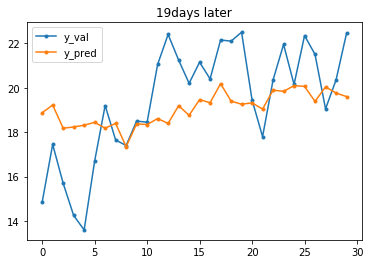

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 1.9453


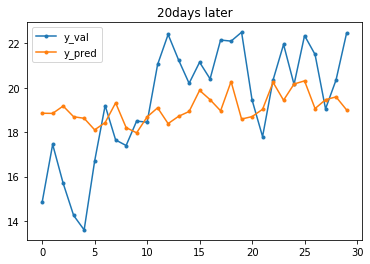

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5]	valid_0's l1: 1.91479


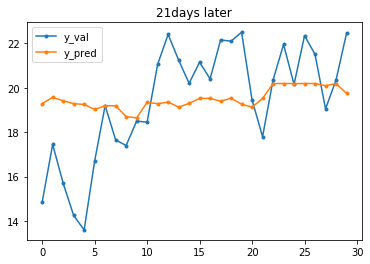

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 1.79498


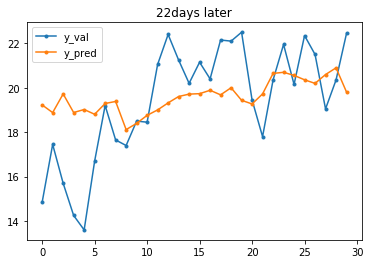

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 1.85747


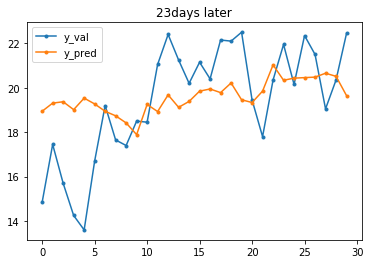

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[14]	valid_0's l1: 1.73656


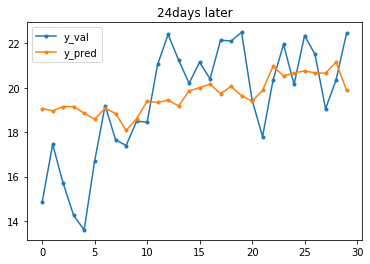

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	valid_0's l1: 1.71718


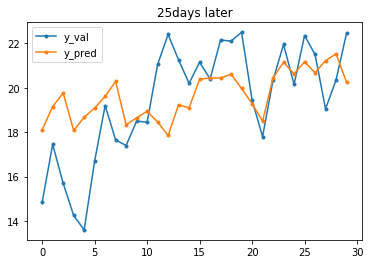

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[38]	valid_0's l1: 1.77672


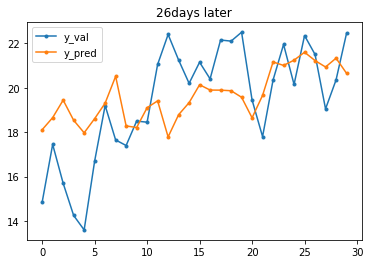

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[128]	valid_0's l1: 1.784


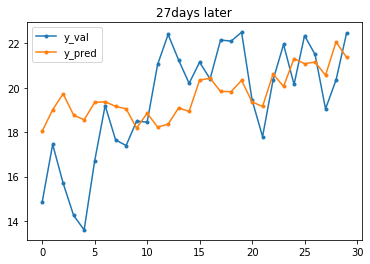

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[91]	valid_0's l1: 1.75183


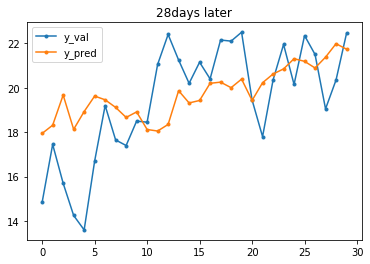

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[91]	valid_0's l1: 1.76685


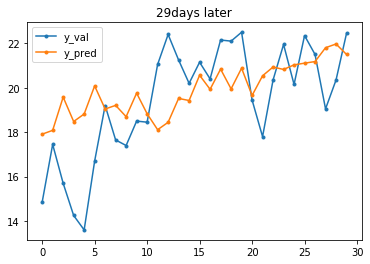

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	valid_0's l1: 1.75899


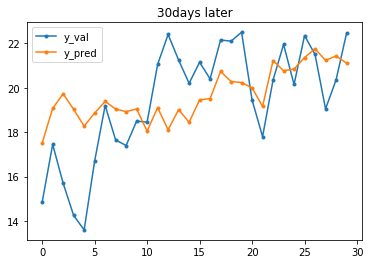

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[109]	valid_0's l1: 1.8838


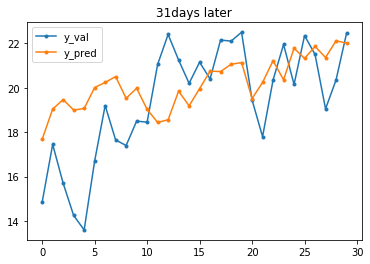

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[93]	valid_0's l1: 1.66223


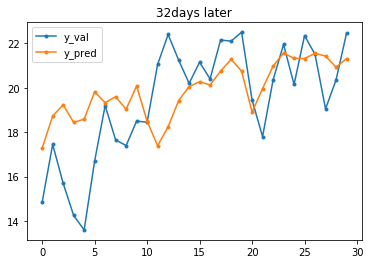

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[12]	valid_0's l1: 1.81751


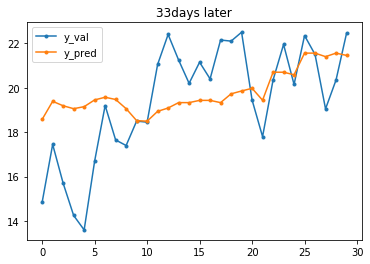

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[12]	valid_0's l1: 1.80528


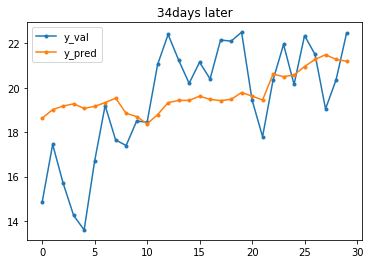

In [53]:
y_columns = ['temp_max']
temp_max_models = {}

for future in range(7,35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)
    
    temp_max_models[future] = create_model(d_train, d_val)
    print('=============================================================')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 2.10682


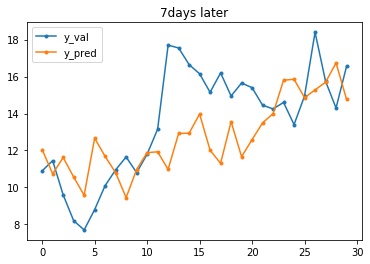

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[10]	valid_0's l1: 2.13751


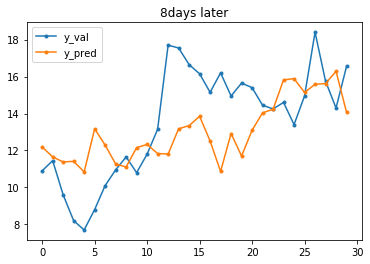

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	valid_0's l1: 2.3342


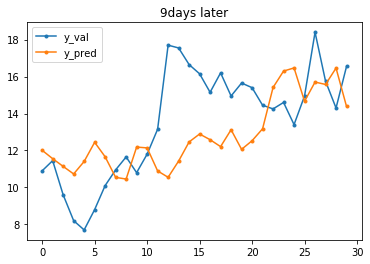

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[31]	valid_0's l1: 2.23053


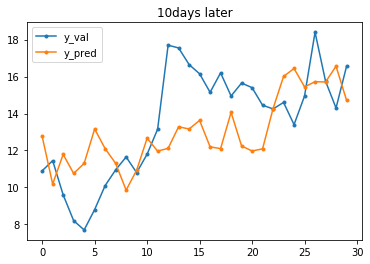

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	valid_0's l1: 2.2732


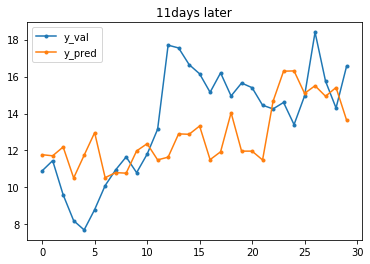

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[13]	valid_0's l1: 2.28065


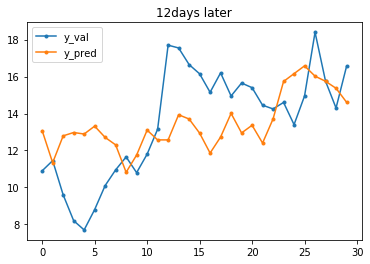

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.20257


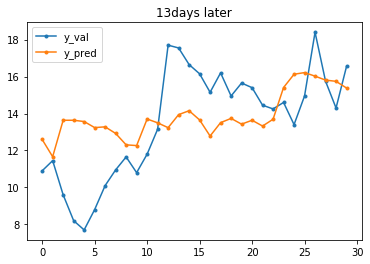

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	valid_0's l1: 2.17865


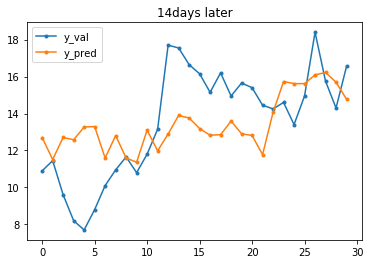

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 2.17244


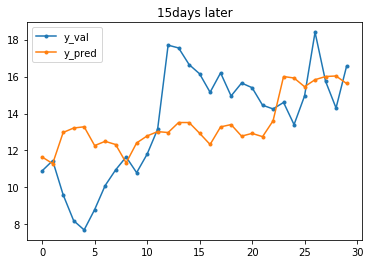

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 2.04645


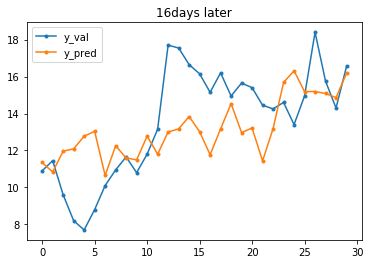

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	valid_0's l1: 2.25942


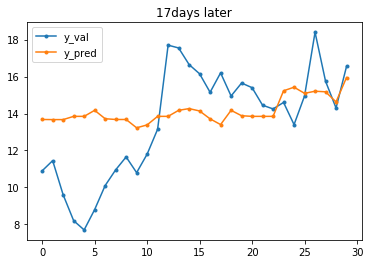

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 2.42899


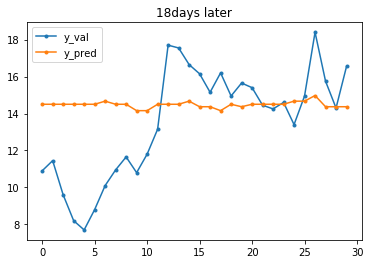

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[10]	valid_0's l1: 2.31391


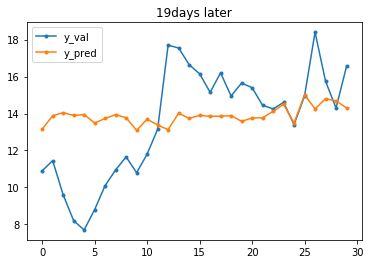

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 2.37363


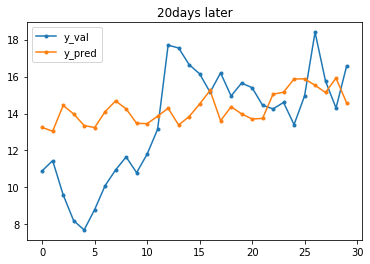

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	valid_0's l1: 2.20156


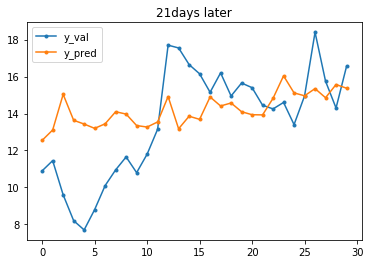

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 2.24308


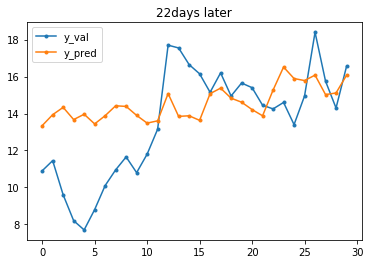

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[37]	valid_0's l1: 2.31012


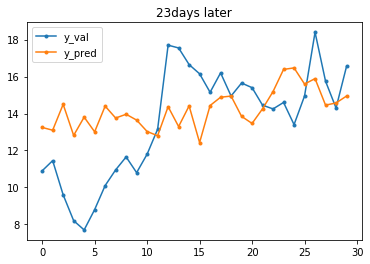

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[14]	valid_0's l1: 2.27835


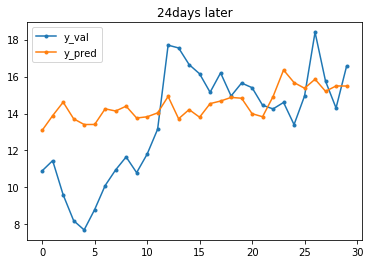

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	valid_0's l1: 2.30703


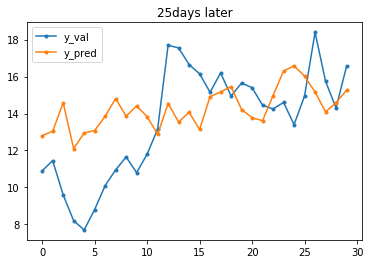

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11]	valid_0's l1: 2.30082


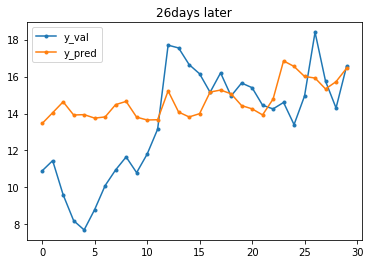

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[9]	valid_0's l1: 2.23807


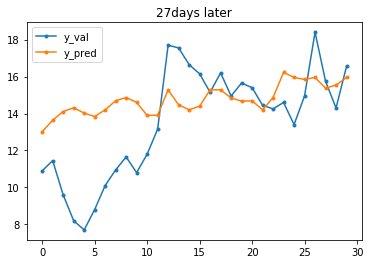

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	valid_0's l1: 2.18869


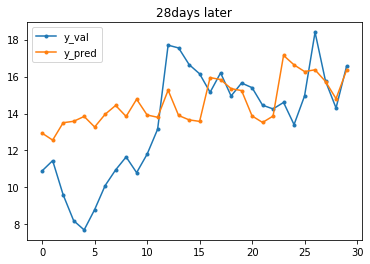

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[112]	valid_0's l1: 2.03065


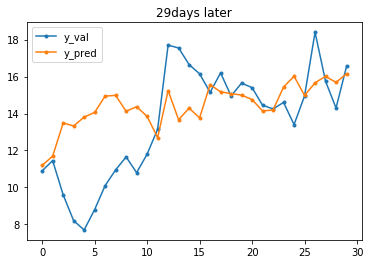

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[411]	valid_0's l1: 2.13319


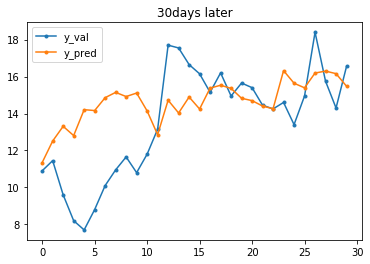

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[243]	valid_0's l1: 2.01297


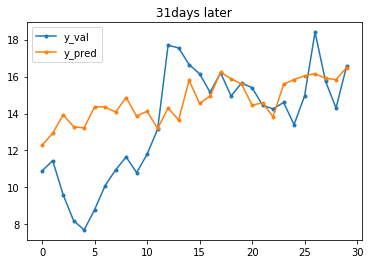

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	valid_0's l1: 2.14907


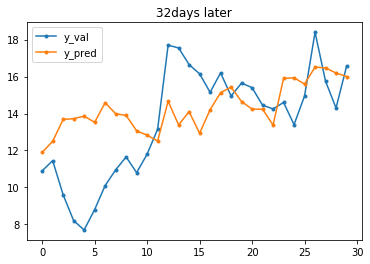

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 2.21201


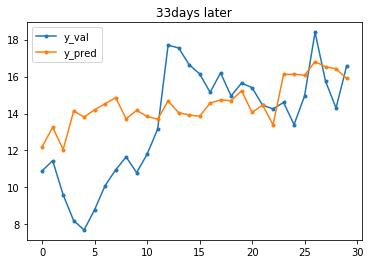

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	valid_0's l1: 2.10178


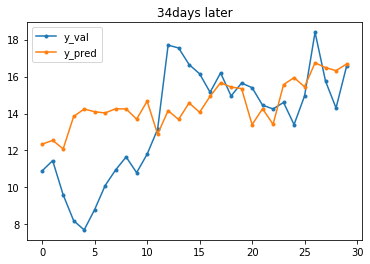

In [54]:
y_columns = ['temp_min']
temp_min_models = {}

for future in range(7,35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target,0,train_split,past,future, x_columns, y_columns)
    x_val, y_val = trans(target,train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)
    
    temp_min_models[future] = create_model(d_train, d_val)
    print('==========================================================')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	valid_0's l1: 2.02477


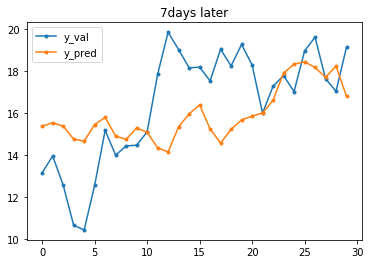

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 2.03354


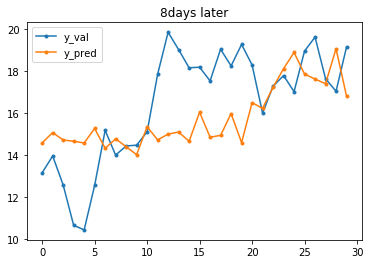

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	valid_0's l1: 2.01944


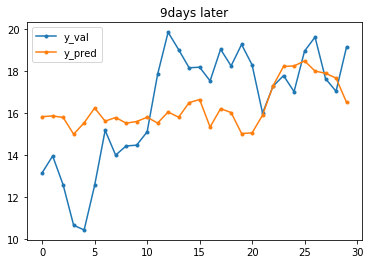

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5]	valid_0's l1: 1.99865


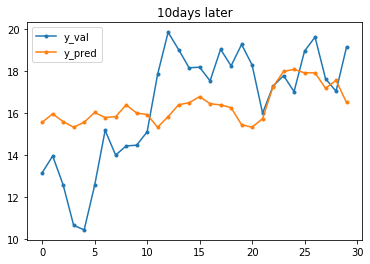

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	valid_0's l1: 1.98191


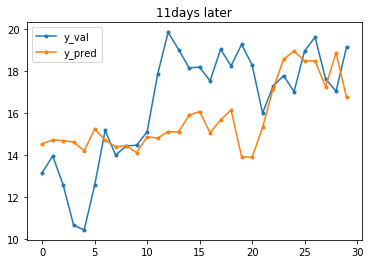

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 1.95354


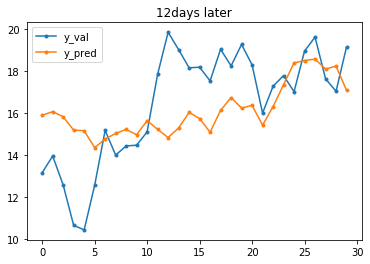

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	valid_0's l1: 1.97646


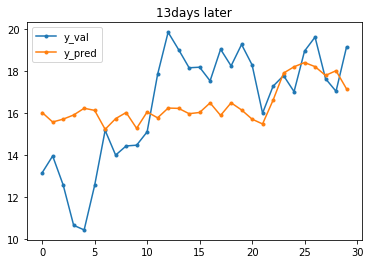

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 2.02888


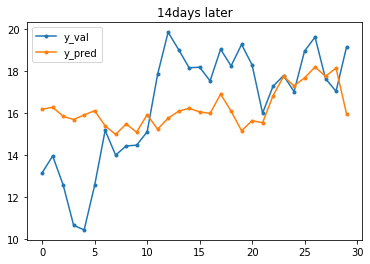

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5]	valid_0's l1: 2.0162


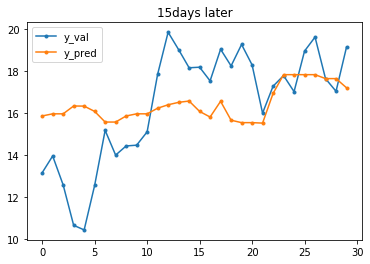

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5]	valid_0's l1: 2.02342


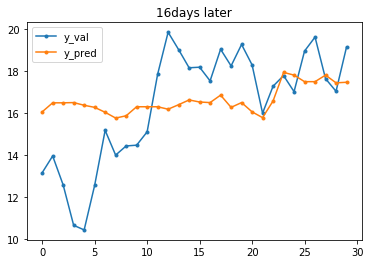

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5]	valid_0's l1: 1.98469


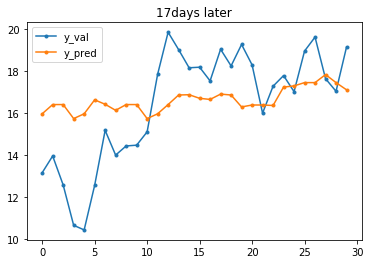

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 2.14574


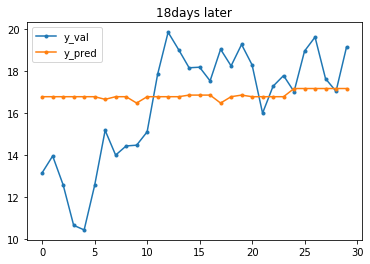

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 2.0209


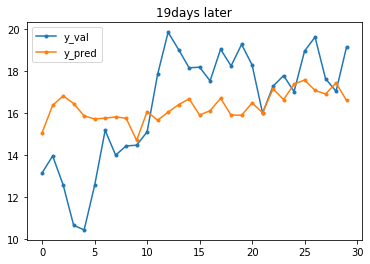

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 2.13406


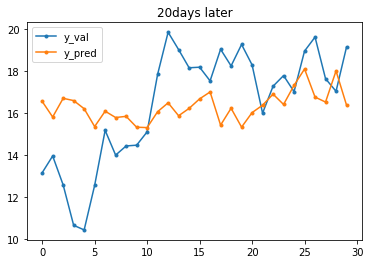

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 1.99638


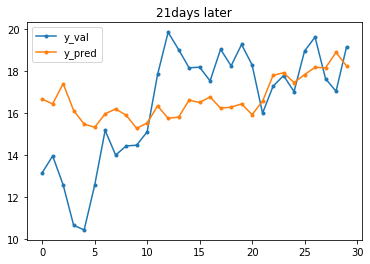

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.9636


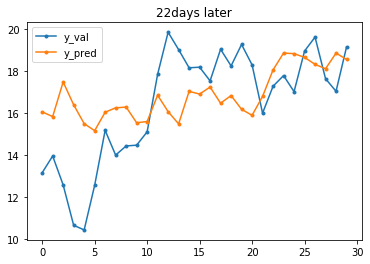

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	valid_0's l1: 2.02128


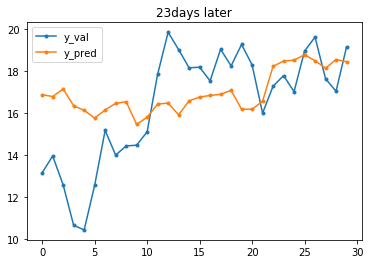

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	valid_0's l1: 1.97633


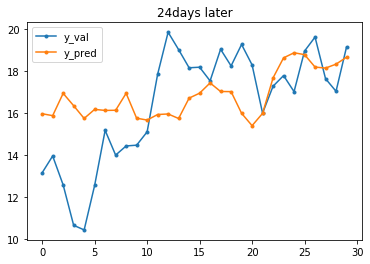

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	valid_0's l1: 1.90863


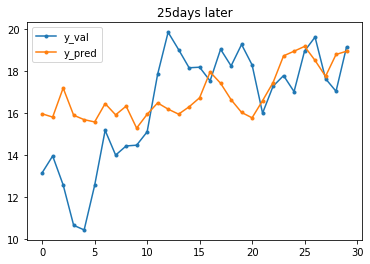

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[67]	valid_0's l1: 1.96563


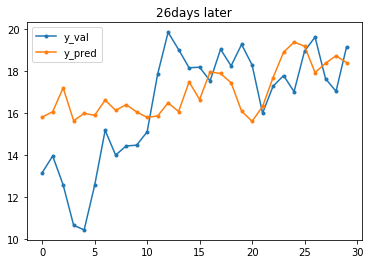

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[36]	valid_0's l1: 1.93084


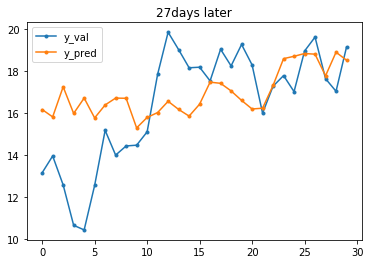

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's l1: 1.88876


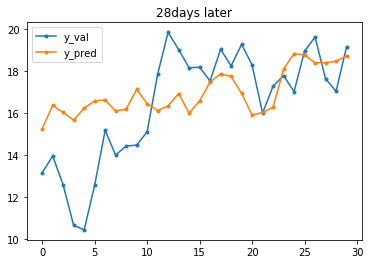

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	valid_0's l1: 1.93516


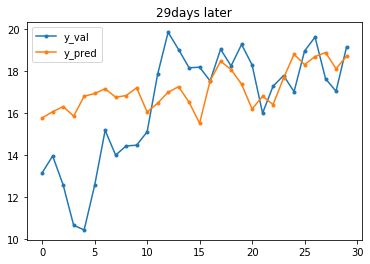

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	valid_0's l1: 1.92617


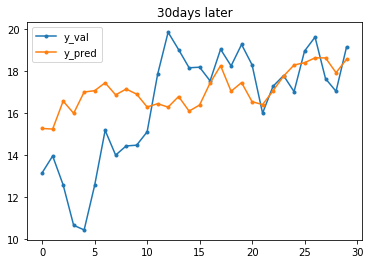

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	valid_0's l1: 1.98859


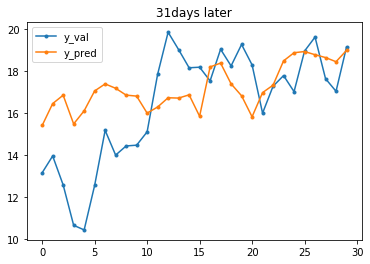

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[67]	valid_0's l1: 2.03271


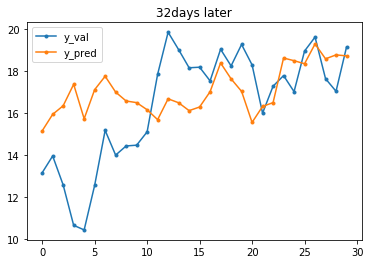

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	valid_0's l1: 1.96517


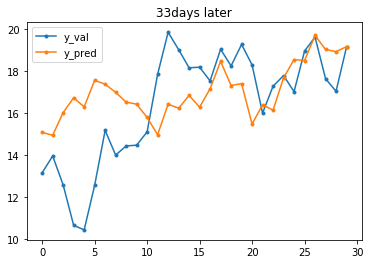

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 2.06545


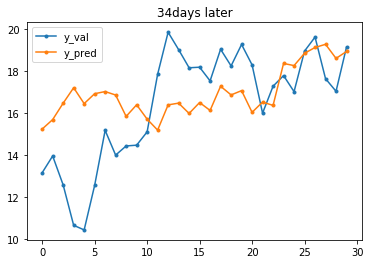

In [55]:
y_columns = ['temp_mean']
temp_mean_models = {}

for future in range(7,35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target,0, train_split, past, future,x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)
    
    temp_mean_models[future] = create_model(d_train, d_val)
    print('=======================================================')

In [56]:
# 총 730개 중에서 validation set 30개 빼고 700부터~
x_test = np.array(target.loc[808:, ['year', 'month', 'day', 'dayofweek', 'supply','holidays', 'temp_max', 'temp_min', 'temp_mean','oil_price']])
# lgb 모델에 넣기 위해서는 한 행으로 만들어야 함
x_test = x_test.reshape(1,-1)

In [57]:
supply_result = []
for future in range(7,35):
    supply_result.append(supply_models[future].predict(x_test))
supply_result = np.array(supply_result).reshape(-1)

In [58]:
oil_price_result = []
for future in range(7,35):
    oil_price_result.append(oil_price_models[future].predict(x_test))
oil_price_result = np.array(oil_price_result).reshape(-1)

In [59]:
x_test = np.array(target.loc[808:, ['year', 'month', 'day', 'temp_max', 'temp_min', 'temp_mean']])
x_test = x_test.reshape(1,-1)

temp_max_result=[]
for future in range(7, 35):
    temp_max_result.append(temp_max_models[future].predict(x_test))
temp_max_result = np.array(temp_max_result).reshape(-1)

In [60]:
temp_min_result=[]
for future in range(7, 35):
    temp_min_result.append(temp_min_models[future].predict(x_test))
temp_min_result = np.array(temp_min_result).reshape(-1)

In [61]:
temp_mean_result=[]
for future in range(7, 35):
    temp_mean_result.append(temp_mean_models[future].predict(x_test))
temp_mean_result = np.array(temp_mean_result).reshape(-1)

In [133]:
submission = pd.read_csv(r'C:\Users\김상휘\Desktop\dacon\sample_submission_v1.csv')

In [134]:
submission_top_half = submission.loc[:27,:]
submission = submission.loc[28:,:]
test = submission.copy()
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['dayofweek'] = test['date'].dt.dayofweek
test['supply'] = np.array(supply_result).reshape(-1)
test['oil_price'] = np.array(oil_price_result).reshape(-1)
test['temp_max'] = np.array(temp_max_result).reshape(-1)
test['temp_min'] = np.array(temp_min_result).reshape(-1)
test['temp_mean'] = np.array(temp_mean_result).reshape(-1)

#공휴일 특성
test = pd.merge(test,holidays,on='date',how='left')
names = test.columns.tolist()
names[names.index('name')] = 'holidays'
test.columns = names
test['holidays'].fillna(0, inplace = True)
for i in range(len(test)):
    if test['holidays'][i] !=0:
        test['holidays'][i] = 1

test['holidays'] = test['holidays'].astype(int)
test.head()

date  smp_max  smp_min  smp_mean     supply  year  month  day  \
0 2020-05-25      0.0      0.0       0.0  65.373150  2020      5   25   
1 2020-05-26      0.0      0.0       0.0  68.021825  2020      5   26   
2 2020-05-27      0.0      0.0       0.0  68.046756  2020      5   27   
3 2020-05-28      0.0      0.0       0.0  67.696324  2020      5   28   
4 2020-05-29      0.0      0.0       0.0  67.755331  2020      5   29   

   dayofweek  oil_price   temp_max   temp_min  temp_mean  holidays  
0          0  37.723600  20.880899  16.308209  18.108919         0  
1          1  37.130764  21.633954  16.366944  20.108756         0  
2          2  40.080009  21.562266  16.901524  18.569149         0  
3          3  40.097023  22.411544  16.735468  18.076823         0  
4          4  41.357751  20.428139  18.484156  19.629902         0

#### 예측된 supply와 날씨데이터를 가지고 smp예측하기

In [136]:
def create_model(x_data, y_data, k=5):
    models = []
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=77)
    
    for train_idx, val_idx in k_fold.split(x_data):
        x_train, y_train = x_data.iloc[train_idx], y_data.iloc[train_idx]
        x_val, y_val = x_data.iloc[val_idx], y_data.iloc[val_idx]
        
        d_train = lgb.Dataset(x_train, y_train)
        d_val = lgb.Dataset(x_val, y_val)
        
        params = {
            'metric':'mse',
            'seed':777
        }
        
        model = lgb.train(params, d_train, 1000, d_val, verbose_eval=1000, early_stopping_rounds = 100)
        
        plt.rcParams['figure.figsize'] = [12,4]
        plt.plot(np.array(y_val),'.-',label='y_val')
        plt.plot(model.predict(x_val),'.-',label='y_pred')
        plt.legend()
        plt.show()
        models.append(model)
    
    return models

In [137]:
x_train = target.loc[:,['supply', 'year', 'month', 'day', 'dayofweek', 'holidays','temp_max', 'temp_min', 'temp_mean','oil_price']]
y_train = target.loc[:, ['smp_min', 'smp_max', 'smp_mean' ]]

train column :  smp_min
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[67]	valid_0's l2: 281.31


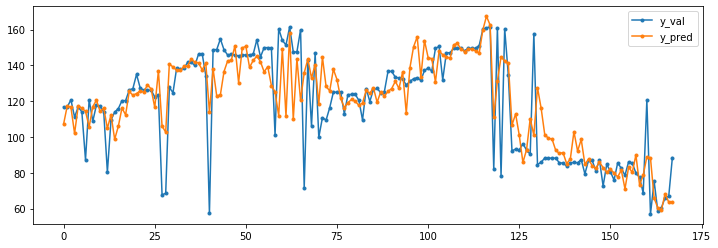

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid_0's l2: 270.978


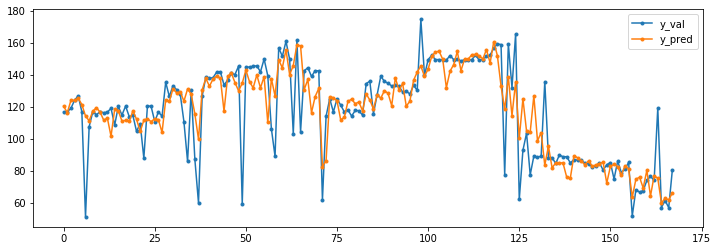

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 248.577


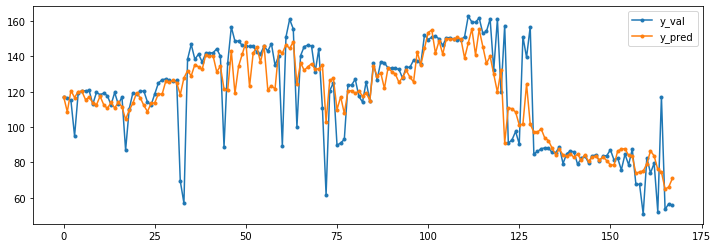

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[39]	valid_0's l2: 158.257


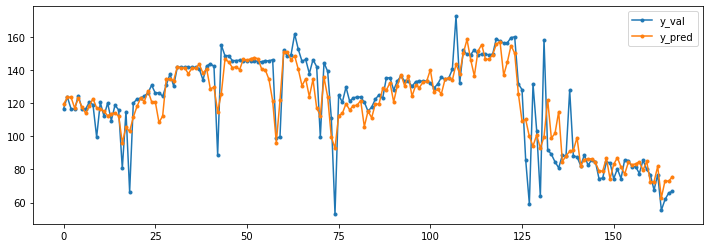

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[31]	valid_0's l2: 170.696


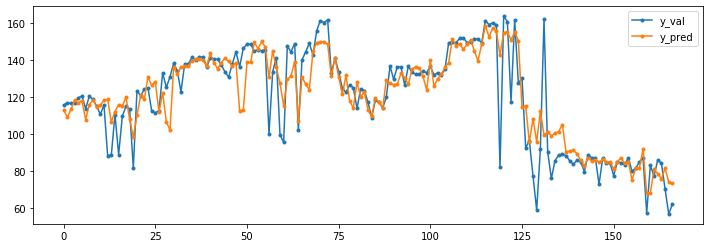

train column :  smp_max
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	valid_0's l2: 406.214


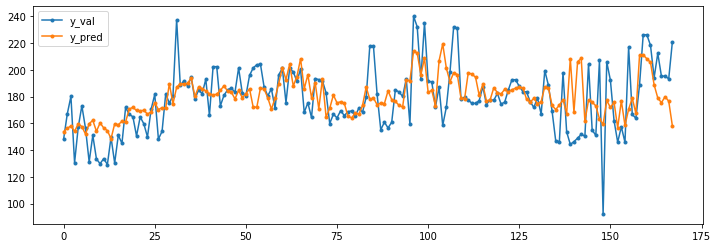

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[10]	valid_0's l2: 865.353


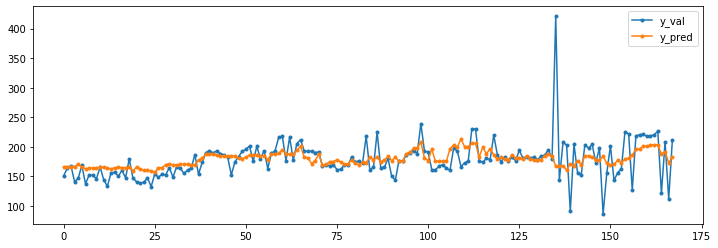

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l2: 460.661


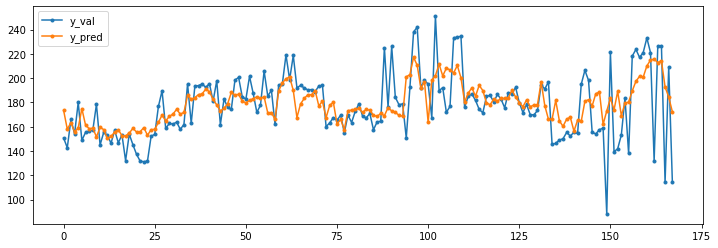

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	valid_0's l2: 1396.4


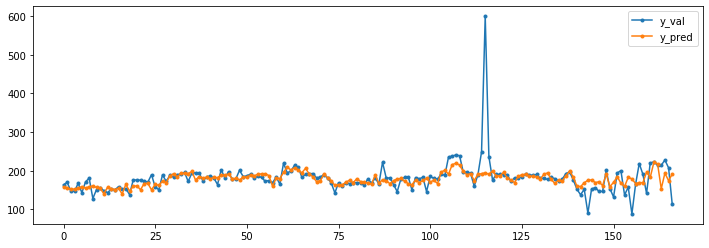

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	valid_0's l2: 348.463


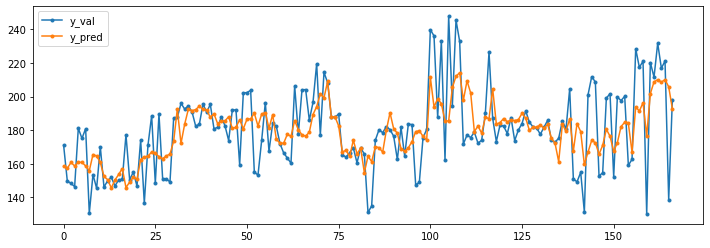

train column :  smp_mean
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[179]	valid_0's l2: 100.659


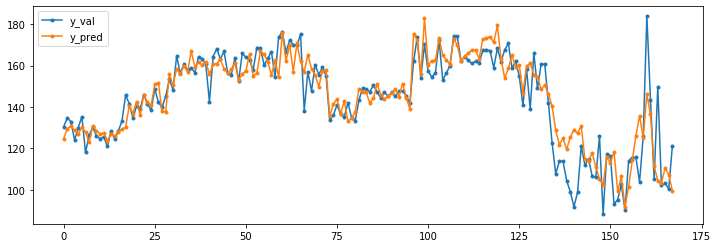

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[379]	valid_0's l2: 96.4108


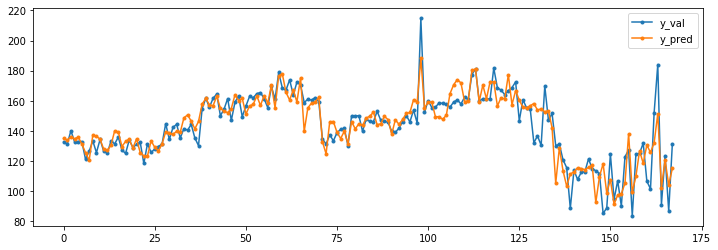

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[214]	valid_0's l2: 120.881


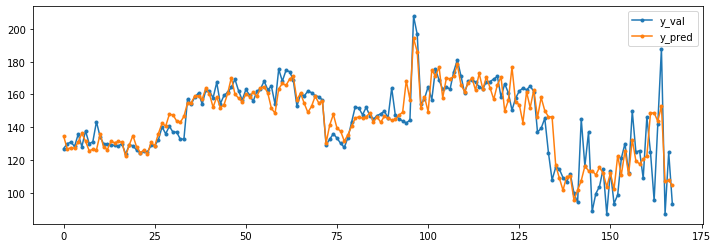

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 96.2225


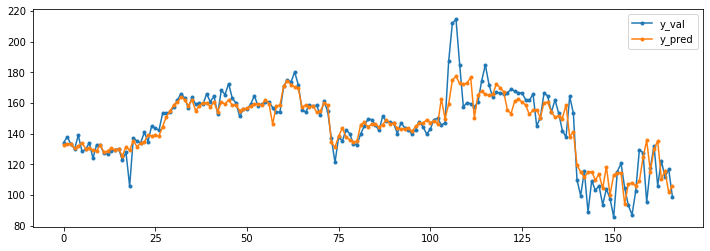

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l2: 86.2435


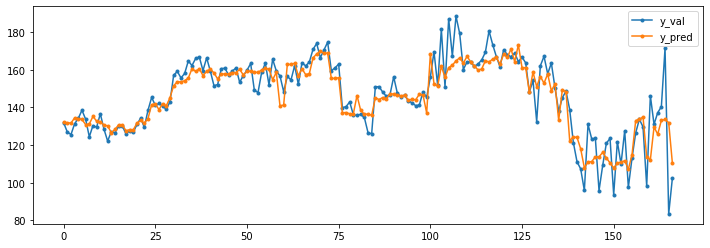

In [138]:
# train과 test를 5개로 나누어서 5번 진행
smp_models = {}
for label in y_train.columns:
    print('train column : ', label)
    smp_models[label] = create_model(x_train, y_train[label])
    print('====================================================')

In [139]:
# 5번 진행된 것을 평균냄
x_test = test.loc[:,['supply', 'year', 'month', 'day', 'dayofweek', 'holidays', 'temp_max', 'temp_min', 'temp_mean','oil_price']]
for label in ['smp_min', 'smp_max', 'smp_mean']:
    preds = []
    for i in range(5):
        preds.append(smp_models[label][i].predict(x_test))
    pred = sum(preds)/len(preds)
    test[label] = pred

In [141]:
submission.reset_index(drop=True, inplace=True)

In [144]:
submission.loc[:, ['smp_min', 'smp_max', 'smp_mean', 'supply']] = test.loc[:,['smp_min', 'smp_max', 'smp_mean', 'supply']]

In [146]:
submission = pd.concat([submission_top_half, submission], axis = 0)
submission.reset_index(drop=True, inplace=True)

date     smp_max    smp_min    smp_mean     supply
0   2020-02-07  201.690000  84.280000  123.620000  84.370000
1   2020-02-08  152.360000  77.420000   93.720000  84.110000
2   2020-02-09  146.770000  74.880000   93.660000  82.410000
3   2020-02-10  173.090000  82.820000  113.480000  83.300000
4   2020-02-11  199.750000  84.910000  121.860000  75.870000
5   2020-02-12  197.670000  84.450000  109.970000  77.110000
6   2020-02-13  198.270000  85.020000  111.640000  74.240000
7   2020-02-14  201.010000  84.300000  103.990000  73.260000
8   2020-02-15  153.830000  84.160000   97.630000  67.030000
9   2020-02-16  132.460000  74.430000   85.700000  83.080000
10  2020-02-17   86.450000  80.430000   85.150000  91.700000
11  2020-02-18  194.370000  80.370000  115.300000  89.340000
12  2020-02-19  200.180000  83.330000  127.680000  84.650000
13  2020-02-20  192.290000  80.650000  116.470000  83.480000
14  2020-02-21  198.250000  79.800000  137.030000  76.180000
15  2020-02-22  162.120000  75.940000   93.110000  78.850000
16  2020-02-23  200.380000  74.510000  120.640000  79.970000
17  2020-02-24  155.390000  83.700000   88.620000  74.340000
18  2020-02-25  155.020000  83.730000   88.740000  71.420000
19  2020-02-26  154.110000  84.270000   99.480000  77.240000
20  2020-02-27  157.680000  80.860000  103.720000  77.310000
21  2020-02-28  201.640000  85.150000  124.590000  81.350000
22  2020-02-29  158.720000  83.670000  114.510000  73.920000
23  2020-03-01  145.930000  85.500000   95.310000  73.400000
24  2020-03-02  143.090000  74.850000   94.480000  82.430000
25  2020-03-03  156.190000  86.010000  106.850000  75.890000
26  2020-03-04   88.220000  83.840000   87.070000  83.860000
27  2020-03-05  157.400000  82.470000  102.690000  84.140000
0   2020-05-25  186.059766  73.824724  111.741211  65.373150
1   2020-05-26  188.763083  73.893368  110.614552  68.021825
2   2020-05-27  190.466062  72.000446  110.995013  68.046756
3   2020-05-28  190.491326  72.653884  112.744732  67.696324
4   2020-05-29  195.995588  71.930016  111.101264  67.755331
5   2020-05-30  183.359875  70.536335  107.886631  67.007553
6   2020-05-31  183.187422  70.891798  109.025793  67.005943
7   2020-06-01  197.824944  70.237585  145.180500  69.478750
8   2020-06-02  199.429359  70.962098  145.441511  69.791938
9   2020-06-03  201.881003  68.630491  147.051364  71.010776
10  2020-06-04  202.498775  68.750491  147.808304  70.724702
11  2020-06-05  203.608777  66.980353  151.385258  70.272313
12  2020-06-06  198.265960  66.879788  149.269235  71.568893
13  2020-06-07  198.169890  69.430086  147.735872  70.266764
14  2020-06-08  205.612213  69.955883  148.898998  71.917207
15  2020-06-09  204.474009  71.819072  147.846998  70.870397
16  2020-06-10  205.564943  70.876461  150.150398  74.681990
17  2020-06-11  173.177964  70.772997  132.815445  74.412150
18  2020-06-12  173.625555  71.107487  133.439371  74.425364
19  2020-06-13  171.375916  73.086105  133.957501  72.941490
20  2020-06-14  173.390939  72.728144  134.474590  72.827347
21  2020-06-15  173.019439  74.257137  134.859048  72.620829
22  2020-06-16  172.258824  75.278068  134.216727  73.157274
23  2020-06-17  172.908993  73.552225  134.413520  73.999159
24  2020-06-18  174.447781  72.966672  133.821346  73.907788
25  2020-06-19  174.471156  73.215844  135.397456  74.716277
26  2020-06-20  172.385157  73.557696  134.463214  74.962126
27  2020-06-21  173.018624  72.882731  133.011831  74.380075

In [149]:
submission.to_csv('Dacon_baseline.csv', index=False)